In [1]:
pip install pydub

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings('ignore')
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os, glob, pickle
import sys
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import preprocessing
import math
from sklearn.neural_network import MLPClassifier
from pydub import AudioSegment
from pydub.playback import play
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import lightgbm as lgb
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMClassifier
   #performance measures
from sklearn.metrics import accuracy_score,log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import multilabel_confusion_matrix


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# PRE-PROCESSING

In [3]:
def Encoder(Original_data,categorical_data):
  le = preprocessing.LabelEncoder()
  for i in categorical_data:
    le.fit(Original_data[i])
    Original_data[i] = le.transform(Original_data[i])
  return Original_data

In [4]:
def loading_data():
  emotion = []
  gender = []
  files = []
  for file in glob.glob("/content/drive/MyDrive/Colab Notebooks/data/speech-emotion-recognition-ravdess-data (1)/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        part = file_name.split('.')[0].split('-')
        emotion.append(int(part[2]))
        bg = int(part[6])
        if bg%2 == 0:
            bg = "female"
        else:
            bg = "male"
        gender.append(bg)
        files.append(file)
  audio_df = pd.DataFrame(emotion)
  # audio_df = audio_df.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
  audio_df = pd.concat([pd.DataFrame(gender),audio_df],axis=1)
  audio_df.columns = ['gender','emotion']
  audio_df_2 = pd.concat([audio_df,pd.DataFrame(files, columns = ['files'])],axis=1)
  return audio_df_2

In [5]:
def data_classified_into_emotions(given_data,emotions_list):
  emotion_wise_data = []
  for i in range(len(emotions_list)):
    d_temp = given_data[given_data['emotion'] == i+1]
    emotion_wise_data.append(d_temp)
  return emotion_wise_data
  

In [6]:
def data_classified_into_gender(given_data):
  gender_wise_data = []
  for i in ['male','female']:
    d_temp = given_data[given_data['gender']]
    gender_wise_data.append(d_temp)
  return gender_wise_data

In [7]:
emotions_list = ['neutral','calm','happy','sad','angry','fear','disgust','surprise']

In [8]:
def standardize(given_data):
  scaler = StandardScaler()
  cols = given_data.columns
  dataset = scaler.fit(given_data).transform()
  return dataset


DATA AUGMENTATION

In [9]:
def addAWGN(signal, num_bits=16, augmented_num=1, snr_low=15, snr_high=30): 
    signal_len = len(signal)
    noise = np.random.normal(size=(augmented_num, signal_len))
    norm_constant = 2.0**(num_bits-1)
    signal_norm = signal / norm_constant
    noise_norm = noise / norm_constant
    s_power = np.sum(signal_norm ** 2) / signal_len
    n_power = np.sum(noise_norm ** 2, axis=1) / signal_len
    target_snr = np.random.randint(snr_low, snr_high)
    K = np.sqrt((s_power / n_power) * 10 ** (- target_snr / 10))
    K = np.ones((signal_len, augmented_num)) * K  
    return signal + K.T * noise

In [10]:
data = loading_data()
data = Encoder(data,['gender'])


In [77]:
data.head()

gender  emotion                                              files
0       1        2  /content/drive/MyDrive/Colab Notebooks/data/sp...
1       1        2  /content/drive/MyDrive/Colab Notebooks/data/sp...
2       1        2  /content/drive/MyDrive/Colab Notebooks/data/sp...
3       1        2  /content/drive/MyDrive/Colab Notebooks/data/sp...
4       1        1  /content/drive/MyDrive/Colab Notebooks/data/sp...

In [11]:
emotion_data = data_classified_into_emotions(data,emotions_list)

VISUALISING

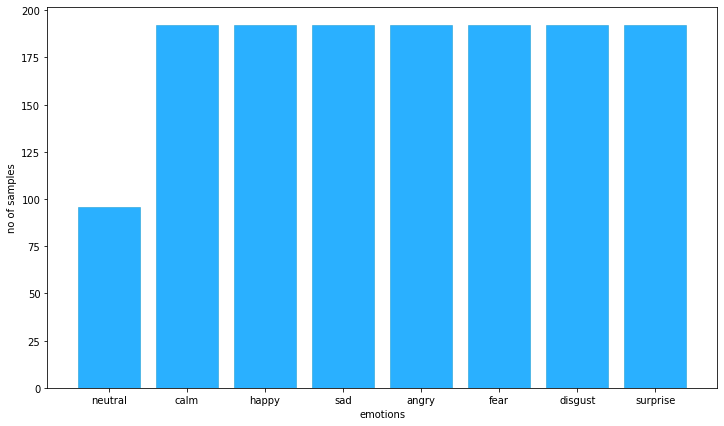

In [12]:
plt.figure(figsize=(12,7))
plt.bar(emotions_list,[i.shape[0] for i in emotion_data],align='center',facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5) 
plt.xlabel('emotions')
plt.ylabel('no of samples')
plt.show()


In [13]:
def confusion_mat(y_pred,y_test):
  conf_matrix = confusion_matrix(y_test,y_pred)
  confmatrix_df = pd.DataFrame(conf_matrix, index=emotions_list, columns=emotions_list)
  print(confmatrix_df)
  # plot confusion matrices
  plt.figure(figsize=(16,6))
  sns.set(font_scale=1.8) # emotion label and title size
  plt.subplot(1,2,1)
  plt.title('Confusion Matrix')
  sns.heatmap(confmatrix_df, annot=True, annot_kws={"size": 18}) #annot_kws is value font
  plt.show()

# FEATURE EXTRACTION

TIME DOMAIN FEATURES:



*   Zero Crossing Rate



In [14]:
def zcr(time_series):
  zcrs = librosa.feature.zero_crossing_rate(time_series)
  zcrs_mean = np.mean(zcrs)
  zcrs_std = np.std(zcrs)
  zcrs_max = np.max(zcrs)
  return zcrs,zcrs_mean,zcrs_std,zcrs_max

def plot_zcr(zrcs):
  plt.figure(figsize=(15,5))
  plt.semilogy(zrcs.T, label='Fraction') # apply log transform on y
  plt.ylabel('Fraction per Frame')
  plt.xticks([])
  plt.legend() 


In [15]:
audio_temp_1 = data['files'][0]
x , sr = librosa.load(audio_temp_1)




*   Root Mean Square Energy



In [16]:
def rmse(time_series):
  return np.sqrt(np.mean(time_series**2))

FREQUENCY DOMAIN FEATURES:



*   Chroma energy distribution normalized statistics (CENS)



In [17]:
def cens(time_series,sampling_rate):
  chroma = librosa.feature.chroma_cens(time_series, sampling_rate)
  chroma_mean = np.mean(chroma,axis = 1)
  chroma_std = np.std(chroma,axis = 1)
  return chroma,chroma_mean,chroma_std

def plot_cens_mean(chroma_mean):
  octave = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
  plt.figure(figsize = (15,7))
  plt.title('Mean CENS')
  sns.barplot(x=octave,y=chroma_mean)

def plot_cens_std(chroma_std):
  octave = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
  plt.figure(figsize = (15,7))
  plt.title('Mean CENS')
  sns.barplot(x=octave,y=chroma_std)



*   Mel spectogram features



In [18]:
def mels(time_series,sampling_rate):
  mel = librosa.feature.melspectrogram(time_series, sampling_rate)
  mel_mean=np.mean(mel.T,axis=0)
  return mel,mel_mean

def plot_mels(mel):
  plt.figure(figsize = (14,14))
  fig, ax = plt.subplots()
  S_dB = librosa.power_to_db(mel, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=sr,fmax=8000, ax=ax)
  fig.colorbar(img, ax=ax, format='%+2.0f dB')
  ax.set(title='Mel-frequency spectrogram')


SPECTRUM SHAPE BASED FEATURES



*   Spectral Centroid



In [19]:
def spec_centroid(time_series,sampling_rate):
   spectral_centroids = librosa.feature.spectral_centroid(time_series, sampling_rate)[0]
   spec_centroid_mean = np.mean(spectral_centroids)
   spec_centroid_variance = np.var(spectral_centroids)
   return spectral_centroids,spec_centroid_mean,spec_centroid_variance

def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)

def plot_spec_centroid(spec_centroids):
  frames = range(len(spec_centroids))
  plt.figure(figsize = (15,7))
  t = librosa.frames_to_time(frames)
  # librosa.display.waveplot(x, sr=sr, alpha=0.4)
  plt.plot(t, normalize(spec_centroids), color='b')



*   Spectral Rolloff


In [20]:
def spec_rolloff(time_series,sampling_rate):
   spectral_rolloff = librosa.feature.spectral_rolloff(time_series+0.01, sampling_rate)[0]
   spec_roll_mean = np.mean(spectral_rolloff)
   spec_roll_variance = np.var(spectral_rolloff)
   return spectral_rolloff,spec_roll_mean,spec_roll_variance

def plot_spec_rolloff(spec_rolloff):
  frames = range(len(spec_rolloff))
  plt.figure(figsize = (15,7))
  t = librosa.frames_to_time(frames)
  # librosa.display.waveplot(x, sr=sr, alpha=0.4)
  plt.plot(t, normalize(spec_rolloff), color='b')



*   Spectral Flux



In [21]:
def spec_flux(time_series,sampling_rate):
   spectral_flux = librosa.onset.onset_strength(time_series, sampling_rate)
   spec_flux_mean = np.mean(spectral_flux) 
   spec_flux_variance = np.var(spectral_flux)
   return spectral_flux,spec_flux_mean,spec_flux_variance



*   Mel frequency cepstral coefficients



In [22]:
def mfcc(time_series,sampling_rate,n_mfccs):
  mfcc = librosa.feature.mfcc(time_series, sampling_rate, n_mfcc=n_mfccs)
  mfcc_mean = np.mean(mfcc.T, axis=0)
  return mfcc,mfcc_mean

def plot_mfcc(mfcc):
  plt.figure(figsize=(15, 7))
  librosa.display.specshow(mfcc, x_axis='time')
  plt.colorbar()
  plt.title('MFCCs') 


n_mfcc vs accuracy analysis

In [23]:
def analysis(model,model_name):
  n_mfcs = [10,20,30,40,50,60,70,80,90,100]
  Acc = []
  for i in n_mfcs:
    mfccs = []
    column = [str(k) for k in range(i)]
    for j in range(data.shape[0]):
      xi,sri =  librosa.load(data['files'][j])
      mfccs.append(mfcc(xi,sri,i))
    A_mfccs = np.array(mfccs)
    mfccs_data = pd.DataFrame(A_mfccs,columns = column)
    x_train,x_test,y_train,y_test = train_test_split(mfccs_data, data['emotion'], test_size=0.20, random_state=11)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    Acc.append(accuracy_score(y_test,y_pred))
  plt.figure(figsize = (8,8))
  plt.plot(n_mfcs,Acc)
  plt.xlabel('n_mfcc')
  plt.ylabel('Accuracy')
  plt.title(model_name)
  plt.show()
  return n_mfcs,Acc


# MAKING DATAFRAME

In [24]:
time_series_original = []
time_series_augmented_1 = []
time_series_augmented_2 = []
time_series_augmented_3 = []
time_series_augmented_4 = []
srs = []
for i in range(data.shape[0]):
  x_i,sr_i = librosa.load(data['files'][i])
  x_i_aug_1 = addAWGN(x_i)[0]
  x_i_aug_2 = addAWGN(x_i)[0]
  x_i_aug_3 = addAWGN(x_i)[0]
  x_i_aug_4 = addAWGN(x_i)[0]
  time_series_original.append(np.array(x_i))
  time_series_augmented_1.append(np.array(x_i_aug_1))
  time_series_augmented_2.append(np.array(x_i_aug_2))
  time_series_augmented_3.append(np.array(x_i_aug_3))
  time_series_augmented_4.append(np.array(x_i_aug_4))
  srs.append(sr_i)


EXTRACTING FEATURES

In [25]:
def return_features(time_series,sampling_rate,n_mfc):
  zcr_mean = []
  zcr_std = []
  zcr_max = []
  rmses = []
  chroma_mean = []
  chroma_std = []
  mel_mean = []
  spec_centroid_means = []
  spec_centroid_variance = []
  spec_rolloff_means = []
  spec_rolloff_variance = []
  spec_flux_means = []
  spec_flux_variance = []
  mfccs = []

  for i in range(len(time_series)):
    z0,z1,z2,z3 = zcr(time_series[i])
    zcr_mean.append(z1)
    zcr_std.append(z2)
    zcr_max.append(z3)
    rmses.append(rmse(time_series[i]))
    c0,c1,c2 = cens(time_series[i],sampling_rate[i])
    chroma_mean.append(c1)
    chroma_std.append(c2)
    m0,m1 = mels(time_series[i],sampling_rate[i])
    mel_mean.append(m1)
    sc0,sc1,sc2 = spec_centroid(time_series[i],sampling_rate[i])
    spec_centroid_means.append(sc1)
    spec_centroid_variance.append(sc2)
    sr0,sr1,sr2 = spec_rolloff(time_series[i],sampling_rate[i])
    spec_rolloff_means.append(sr1)
    spec_rolloff_variance.append(sr2)
    sf0,sf1,sf2 = spec_flux(time_series[i],sampling_rate[i])
    spec_flux_means.append(sf1)
    spec_flux_variance.append(sf2)
    mc0,mc1 = mfcc(time_series[i],sampling_rate[i],n_mfc)
    mfccs.append(mc1)

  dict1 = {}
  dict1['zcr_mean'] = zcr_mean
  dict1['zcr_std'] = zcr_std
  dict1['zcr_max'] = zcr_max
  dict1['rmse'] = rmses
  dict1['chroma_mean'] = chroma_mean
  dict1['chroma_std'] = chroma_std
  dict1['mel_mean'] = mel_mean
  dict1['spec_centroid_mean'] = spec_centroid_means
  dict1['spec_centroid_variance'] = spec_centroid_variance
  dict1['spec_roll_mean'] = spec_rolloff_means
  dict1['spec_roll_variance'] = spec_rolloff_variance
  dict1['spec_flux_mean'] = spec_flux_means
  dict1['spec_flux_variance'] = spec_flux_variance
  dict1['mfcc'] = mfccs
  return dict1


In [26]:
original_features = return_features(time_series_original,srs,40)

In [27]:
augmented_features_1 = return_features(time_series_augmented_1,srs,40)
augmented_features_2 = return_features(time_series_augmented_2,srs,40)
augmented_features_3 = return_features(time_series_augmented_3,srs,40)
augmented_features_4 = return_features(time_series_augmented_4,srs,40)

Display augmented signal.

Text(0, 0.5, 'Signal')

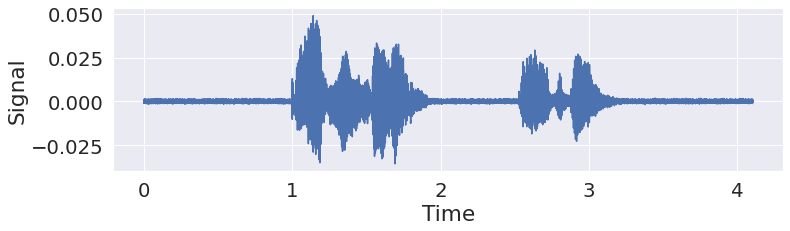

In [96]:
from IPython.core.pylabtools import figsize
x1,sr1 =  librosa.load(data['files'][0])
x1_aug = addAWGN(x1)[0]
time=np.linspace(0,len(x1_aug)/sr1,num=len(x1_aug))
plt.figure(figsize=(12,3))
plt.plot(time,x1_aug)
plt.xlabel("Time")
plt.ylabel("Signal")

MAKING DATAFRAME

In [28]:
def make_data(features_dictionary,original_data,features_to_choose):
  dataset = pd.DataFrame()
  for i in features_to_choose:
    if(i != 'mfcc' and i != 'chroma_mean' and i != 'chroma_std' and i!='mel_mean'):
      dataset[i] = features_dictionary[i]
    elif(i == 'mfcc'):
      Arr = np.array(features_dictionary[i])
      mfccs_data = pd.DataFrame(Arr,columns = ['m'+str(k) for k in range(len(Arr[0]))])
      dataset = pd.concat([mfccs_data,dataset],axis = 1)
    elif(i == 'chroma_mean'):
      Arr = np.array(features_dictionary[i])
      chroma_mean_data = pd.DataFrame(Arr,columns = ['C_mean','C#_mean','D_mean','D#_mean','E_mean','F_mean','F#_mean','G_mean','G#_mean','A_mean','A#_mean','B_mean'])
      dataset = pd.concat([chroma_mean_data,dataset],axis = 1)
    elif(i == 'chroma_std'):
      Arr = np.array(features_dictionary[i])
      chroma_std_data = pd.DataFrame(Arr,columns = ['C_std','C#_std','D_std','D#_std','E_std','F_std','F#_std','G_std','G#_std','A_std','A#_std','B_std'])
      dataset = pd.concat([chroma_std_data,dataset],axis = 1)
    elif(i == 'mel_mean'):
      Arr = np.array(features_dictionary[i])
      mel_mean_data = pd.DataFrame(Arr,columns = [str(k) for k in range(128)])
      dataset = pd.concat([mel_mean_data,dataset],axis = 1)


  dataset_x = dataset.copy(deep = True)
  dataset_y = original_data['emotion']
  dataset['emotion'] = original_data['emotion']
  return dataset,dataset_x,dataset_y


In [29]:
time_domain_data,time_domain_data_x,time_domain_data_y = make_data(original_features,data,['zcr_mean','zcr_std','zcr_max','rmse'])
frequency_domain_data,frequency_domain_data_x,frequency_domain_data_y = make_data(original_features,data,['chroma_mean','chroma_std','mel_mean'])
spectral_domain_data,spectral_domain_data_x,spectral_domain_data_y = make_data(original_features,data,['spec_centroid_mean','spec_centroid_variance','spec_roll_mean','spec_roll_variance','spec_flux_mean','spec_flux_variance','mfcc'])
all_features_data,all_features_data_x,all_features_data_y = make_data(original_features,data,['zcr_mean','zcr_std','zcr_max','rmse','chroma_mean','chroma_std','mel_mean','spec_centroid_mean','spec_centroid_variance','spec_roll_mean','spec_roll_variance','spec_flux_mean','spec_flux_variance','mfcc'])
only_mfcc_data,only_mfcc_data_x,only_mfcc_data_y = make_data(original_features,data,['mfcc'])
td_x_train,td_x_test,td_y_train,td_y_test = train_test_split(time_domain_data_x,time_domain_data_y, test_size=0.25, random_state=11)
fd_x_train,fd_x_test,fd_y_train,fd_y_test = train_test_split(frequency_domain_data_x,frequency_domain_data_y, test_size=0.25, random_state=11)
sd_x_train,sd_x_test,sd_y_train,sd_y_test = train_test_split(spectral_domain_data_x,spectral_domain_data_y, test_size=0.25, random_state=11)
all_x_train,all_x_test,all_y_train,all_y_test = train_test_split(all_features_data_x,all_features_data_y, test_size=0.25, random_state=11)
omfc_x_train,omfc_x_test,omfc_y_train,omfc_y_test = train_test_split(only_mfcc_data_x,only_mfcc_data_y, test_size=0.25, random_state=11)

In [30]:
print(time_domain_data_x.columns)

Index(['zcr_mean', 'zcr_std', 'zcr_max', 'rmse'], dtype='object')


In [31]:
augmented1_time,augmented1_time_x,augmented1_y = make_data(augmented_features_1,data,['zcr_mean','zcr_std','zcr_max','rmse'])
augmented1_frequency,augmented1_frequency_x,augmented1_frequency_y = make_data(augmented_features_1,data,['chroma_mean','chroma_std','mel_mean'])
augmented1_spectral,augmented1_spectral_x,augmented1_spectral_y = make_data(augmented_features_1,data,['spec_centroid_mean','spec_centroid_variance','spec_roll_mean','spec_roll_variance','spec_flux_mean','spec_flux_variance','mfcc'])
augmented1_all,augmented1_all_x,augmented1_all_y = make_data(augmented_features_1,data,['zcr_mean','zcr_std','zcr_max','rmse','chroma_mean','chroma_std','mel_mean','spec_centroid_mean','spec_centroid_variance','spec_roll_mean','spec_roll_variance','spec_flux_mean','spec_flux_variance','mfcc'])
augmented1_mfcc,augmented1_mfcc_x,augmented1_mfcc_y = make_data(augmented_features_1,data,['mfcc'])

In [32]:
augmented2_time,augmented2_time_x,augmented2_y = make_data(augmented_features_2,data,['zcr_mean','zcr_std','zcr_max','rmse'])
augmented2_frequency,augmented2_frequency_x,augmented2_frequency_y = make_data(augmented_features_2,data,['chroma_mean','chroma_std','mel_mean'])
augmented2_spectral,augmented2_spectral_x,augmented2_spectral_y = make_data(augmented_features_2,data,['spec_centroid_mean','spec_centroid_variance','spec_roll_mean','spec_roll_variance','spec_flux_mean','spec_flux_variance','mfcc'])
augmented2_all,augmented2_all_x,augmented2_all_y = make_data(augmented_features_2,data,['zcr_mean','zcr_std','zcr_max','rmse','chroma_mean','chroma_std','mel_mean','spec_centroid_mean','spec_centroid_variance','spec_roll_mean','spec_roll_variance','spec_flux_mean','spec_flux_variance','mfcc'])
augmented2_mfcc,augmented2_mfcc_x,augmented2_mfcc_y = make_data(augmented_features_2,data,['mfcc'])

In [33]:
augmented3_time,augmented3_time_x,augmented3_y = make_data(augmented_features_3,data,['zcr_mean','zcr_std','zcr_max','rmse'])
augmented3_frequency,augmented3_frequency_x,augmented3_frequency_y = make_data(augmented_features_3,data,['chroma_mean','chroma_std','mel_mean'])
augmented3_spectral,augmented3_spectral_x,augmented3_spectral_y = make_data(augmented_features_3,data,['spec_centroid_mean','spec_centroid_variance','spec_roll_mean','spec_roll_variance','spec_flux_mean','spec_flux_variance','mfcc'])
augmented3_all,augmented3_all_x,augmented3_all_y = make_data(augmented_features_3,data,['zcr_mean','zcr_std','zcr_max','rmse','chroma_mean','chroma_std','mel_mean','spec_centroid_mean','spec_centroid_variance','spec_roll_mean','spec_roll_variance','spec_flux_mean','spec_flux_variance','mfcc'])
augmented3_mfcc,augmented3_mfcc_x,augmented3_mfcc_y = make_data(augmented_features_3,data,['mfcc'])

In [34]:
augmented4_time,augmented4_time_x,augmented4_y = make_data(augmented_features_4,data,['zcr_mean','zcr_std','zcr_max','rmse'])
augmented4_frequency,augmented4_frequency_x,augmented4_frequency_y = make_data(augmented_features_4,data,['chroma_mean','chroma_std','mel_mean'])
augmented4_spectral,augmented4_spectral_x,augmented4_spectral_y = make_data(augmented_features_4,data,['spec_centroid_mean','spec_centroid_variance','spec_roll_mean','spec_roll_variance','spec_flux_mean','spec_flux_variance','mfcc'])
augmented4_all,augmented4_all_x,augmented4_all_y = make_data(augmented_features_4,data,['zcr_mean','zcr_std','zcr_max','rmse','chroma_mean','chroma_std','mel_mean','spec_centroid_mean','spec_centroid_variance','spec_roll_mean','spec_roll_variance','spec_flux_mean','spec_flux_variance','mfcc'])
augmented4_mfcc,augmented4_mfcc_x,augmented4_mfcc_y = make_data(augmented_features_4,data,['mfcc'])

In [35]:
augmented_final_time_x = pd.concat([augmented1_time_x,augmented2_time_x,augmented3_time_x,augmented4_time_x])
augmented_final_time_y = pd.concat([augmented1_y,augmented2_y,augmented3_y,augmented4_y])

In [36]:
augmented_final_frequency_x = pd.concat([augmented1_frequency_x,augmented2_frequency_x,augmented3_frequency_x,augmented4_frequency_x])
augmented_final_frequency_y = pd.concat([augmented1_frequency_y,augmented2_frequency_y,augmented3_frequency_y,augmented4_frequency_y])

In [37]:
augmented_final_spectral_x = pd.concat([augmented1_spectral_x,augmented2_spectral_x,augmented3_spectral_x,augmented4_spectral_x])
augmented_final_spectral_y = pd.concat([augmented1_spectral_y,augmented2_spectral_y,augmented3_spectral_y,augmented4_spectral_y])

In [38]:
augmented_final_all_x = pd.concat([augmented1_all_x,augmented2_all_x,augmented3_all_x,augmented4_all_x])
augmented_final_all_y = pd.concat([augmented1_all_y,augmented2_all_y,augmented3_all_y,augmented4_all_y])

In [39]:
augmented_final_mfcc_x = pd.concat([augmented1_mfcc_x,augmented2_mfcc_x,augmented3_mfcc_x,augmented4_mfcc_x])
augmented_final_mfcc_y = pd.concat([augmented1_mfcc_y,augmented2_mfcc_y,augmented3_mfcc_y,augmented4_mfcc_y])

In [40]:
agtd_x_train,agtd_x_test,agtd_y_train,agtd_y_test = train_test_split(augmented_final_time_x,augmented_final_time_y, test_size=0.25, random_state=11)
agfd_x_train,agfd_x_test,agfd_y_train,agfd_y_test = train_test_split(augmented_final_frequency_x,augmented_final_frequency_y, test_size=0.25, random_state=11)
agsd_x_train,agsd_x_test,agsd_y_train,agsd_y_test = train_test_split(augmented_final_spectral_x,augmented_final_spectral_y, test_size=0.25, random_state=11)
agall_x_train,agall_x_test,agall_y_train,agall_y_test = train_test_split(augmented_final_all_x,augmented_final_all_y, test_size=0.25, random_state=11)
agomfc_x_train,agomfc_x_test,agomfc_y_train,agomfc_y_test = train_test_split(augmented_final_mfcc_x,augmented_final_mfcc_y, test_size=0.25, random_state=11)

In [41]:
agtd_x_train.info()
agtd_x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4320 entries, 101 to 505
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   zcr_mean  4320 non-null   float64
 1   zcr_std   4320 non-null   float64
 2   zcr_max   4320 non-null   float64
 3   rmse      4320 non-null   float64
dtypes: float64(4)
memory usage: 168.8 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 792 to 987
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   zcr_mean  1440 non-null   float64
 1   zcr_std   1440 non-null   float64
 2   zcr_max   1440 non-null   float64
 3   rmse      1440 non-null   float64
dtypes: float64(4)
memory usage: 56.2 KB


# BASE MODELS

In [42]:
model_dict={}

In [43]:
aug_model_dict={}

In [44]:
def model_classifier(model,dataset_dict,model_name,model_store):
  model_dict1={}
  data_name=list(dataset_dict.keys())
  datasets=list(dataset_dict.values())
  print("Model :",model_name)
  for i in range(len(data_name)):
    print(f"For {data_name[i]}",end="\n")
    # new_model = model
    model.fit(datasets[i][0],datasets[i][2])
    name=data_name[i]+".pkl"
    pickle.dump(model,open(name,"wb"))
    model_dict1[data_name[i]]=model
    y_pred = model.predict(datasets[i][1])
    print("Accuracy score : ",accuracy_score(datasets[i][3],y_pred))
    print(classification_report(datasets[i][3], y_pred))
    confusion_mat(datasets[i][3],y_pred)
  model_store[model_name]=model_dict1

In [45]:
dataset_dict={"time_domain_data":[td_x_train,td_x_test,td_y_train,td_y_test],
              "frequency_domain_data":[fd_x_train,fd_x_test,fd_y_train,fd_y_test],
              "spectral_domain_data":[sd_x_train,sd_x_test,sd_y_train,sd_y_test],
              "only_mfcc_data":[omfc_x_train,omfc_x_test,omfc_y_train,omfc_y_test],
              "all_features_data":[all_x_train,all_x_test,all_y_train,all_y_test]}

In [46]:
aug_dict = {"time_domain_data":[agtd_x_train,agtd_x_test,agtd_y_train,agtd_y_test],
              "frequency_domain_data":[agfd_x_train,agfd_x_test,agfd_y_train,agfd_y_test],
              "spectral_domain_data":[agsd_x_train,agsd_x_test,agsd_y_train,agsd_y_test],
              "only_mfcc_data":[agomfc_x_train,agomfc_x_test,agomfc_y_train,agomfc_y_test],
              "all_features_data":[agall_x_train,agall_x_test,agall_y_train,agall_y_test]}

DOWNLOADING THESE DATASETS FOR BACKEND OF OUR DEPLOYMENT

In [47]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [48]:
for key,value in aug_dict.items():
  for j in value:
    df = j
    from google.colab import files
    df.to_csv(str(get_df_name(j))+".csv")
    files.download(str(get_df_name(j))+".csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Decision Tree

Model : Decision Tree Classifier
For time_domain_data
Accuracy score :  0.2777777777777778
              precision    recall  f1-score   support

           1       0.20      0.21      0.20        24
           2       0.54      0.48      0.51        65
           3       0.16      0.15      0.16        46
           4       0.26      0.28      0.27        53
           5       0.39      0.40      0.40        40
           6       0.19      0.20      0.20        44
           7       0.14      0.18      0.16        38
           8       0.27      0.20      0.23        50

    accuracy                           0.28       360
   macro avg       0.27      0.26      0.26       360
weighted avg       0.29      0.28      0.28       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         5     7      0    6      1     2        3         1
calm            4    31      1    9      2     2        5         3
happy           2     2      7    7      6     4      

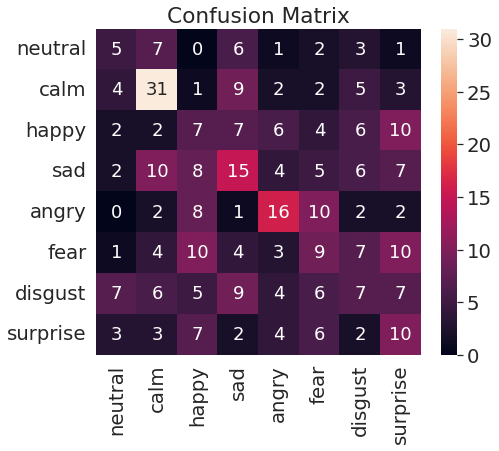

For frequency_domain_data
Accuracy score :  0.3194444444444444
              precision    recall  f1-score   support

           1       0.17      0.17      0.17        24
           2       0.57      0.52      0.54        65
           3       0.22      0.17      0.20        46
           4       0.20      0.21      0.20        53
           5       0.47      0.42      0.45        40
           6       0.28      0.25      0.26        44
           7       0.24      0.29      0.27        38
           8       0.30      0.38      0.33        50

    accuracy                           0.32       360
   macro avg       0.31      0.30      0.30       360
weighted avg       0.32      0.32      0.32       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         4     6      1    7      0     1        1         3
calm            6    34      2   13      0     2        2         1
happy           2     4      8    3      4     7        2         6
sad           

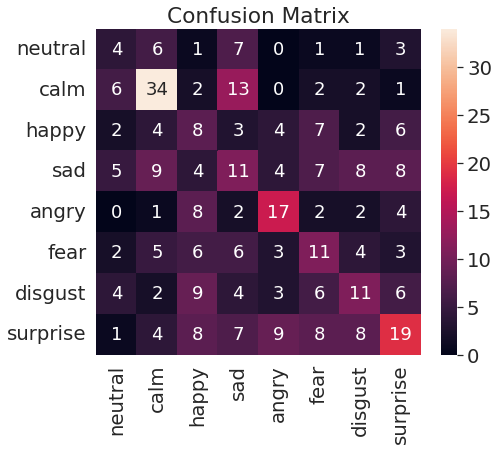

For spectral_domain_data
Accuracy score :  0.3333333333333333
              precision    recall  f1-score   support

           1       0.26      0.29      0.27        24
           2       0.41      0.42      0.41        65
           3       0.30      0.30      0.30        46
           4       0.29      0.17      0.21        53
           5       0.56      0.45      0.50        40
           6       0.35      0.32      0.33        44
           7       0.23      0.39      0.29        38
           8       0.31      0.32      0.31        50

    accuracy                           0.33       360
   macro avg       0.34      0.33      0.33       360
weighted avg       0.34      0.33      0.33       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         7     6      2    6      0     2        1         3
calm           11    27      3   14      1     2        4         4
happy           0     3     14    5      4     8        7         5
sad            

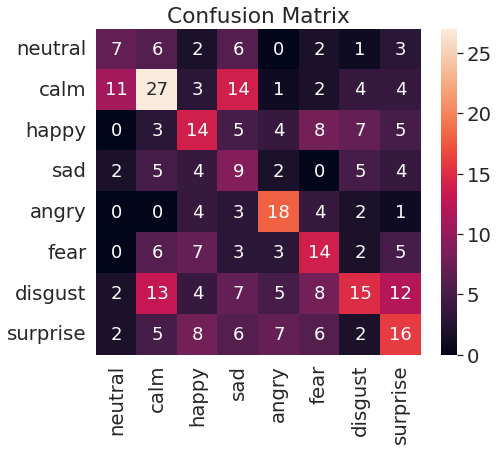

For only_mfcc_data
Accuracy score :  0.39166666666666666
              precision    recall  f1-score   support

           1       0.35      0.38      0.36        24
           2       0.53      0.48      0.50        65
           3       0.30      0.30      0.30        46
           4       0.48      0.38      0.42        53
           5       0.46      0.55      0.50        40
           6       0.39      0.34      0.37        44
           7       0.27      0.39      0.32        38
           8       0.33      0.30      0.32        50

    accuracy                           0.39       360
   macro avg       0.39      0.39      0.39       360
weighted avg       0.40      0.39      0.39       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         9     8      2    2      1     0        2         2
calm            9    31      0   10      2     1        4         2
happy           0     5     14    4      6     7        4         7
sad             2   

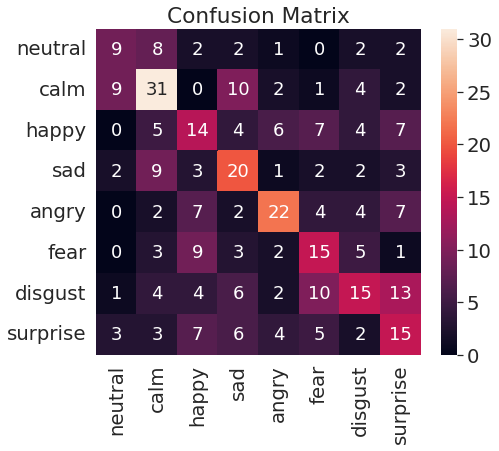

For all_features_data
Accuracy score :  0.3638888888888889
              precision    recall  f1-score   support

           1       0.17      0.17      0.17        24
           2       0.61      0.48      0.53        65
           3       0.27      0.30      0.29        46
           4       0.29      0.26      0.27        53
           5       0.54      0.53      0.53        40
           6       0.47      0.39      0.42        44
           7       0.25      0.37      0.30        38
           8       0.30      0.32      0.31        50

    accuracy                           0.36       360
   macro avg       0.36      0.35      0.35       360
weighted avg       0.38      0.36      0.37       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         4     5      1    7      1     3        2         1
calm            4    31      0    7      0     1        5         3
happy           3     5     14    6      3     7        6         8
sad             6 

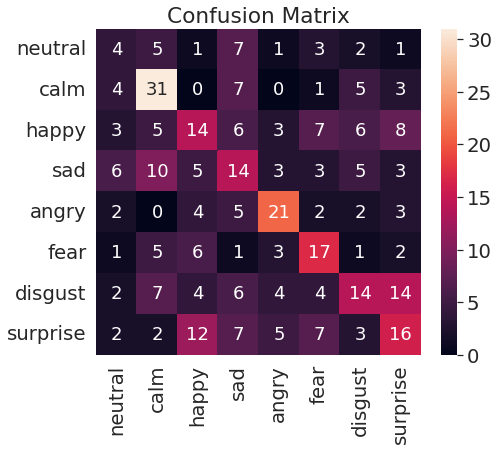

In [49]:
model_1=DecisionTreeClassifier(random_state=39)
model_classifier(model_1,dataset_dict,"Decision Tree Classifier",model_dict)

Random Forest

Model : Random ForestClassifier
For time_domain_data
Accuracy score :  0.26666666666666666
              precision    recall  f1-score   support

           1       0.25      0.17      0.20        24
           2       0.49      0.49      0.49        65
           3       0.16      0.17      0.16        46
           4       0.20      0.17      0.18        53
           5       0.38      0.33      0.35        40
           6       0.23      0.25      0.24        44
           7       0.17      0.29      0.22        38
           8       0.21      0.16      0.18        50

    accuracy                           0.27       360
   macro avg       0.26      0.25      0.25       360
weighted avg       0.27      0.27      0.27       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         4     4      0    4      1     2        1         0
calm            5    32      3   15      0     2        6         2
happy           2     1      8    7      9     6      

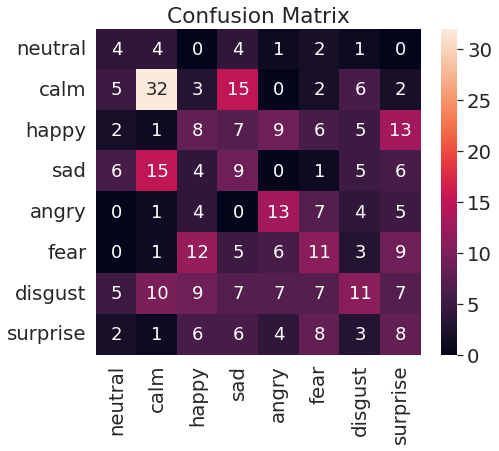

For frequency_domain_data
Accuracy score :  0.475
              precision    recall  f1-score   support

           1       0.60      0.25      0.35        24
           2       0.57      0.78      0.66        65
           3       0.33      0.30      0.32        46
           4       0.50      0.45      0.48        53
           5       0.64      0.45      0.53        40
           6       0.55      0.36      0.44        44
           7       0.28      0.39      0.33        38
           8       0.45      0.54      0.49        50

    accuracy                           0.48       360
   macro avg       0.49      0.44      0.45       360
weighted avg       0.49      0.47      0.47       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         6     4      0    0      0     0        0         0
calm            9    51      1   14      0     2        8         4
happy           1     1     14    7      3     6        5         5
sad             4     7    

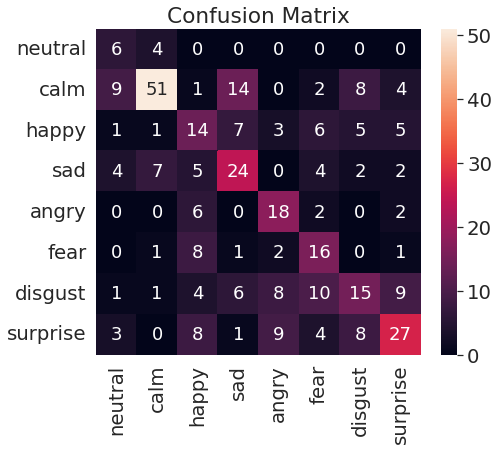

For spectral_domain_data
Accuracy score :  0.5222222222222223
              precision    recall  f1-score   support

           1       0.25      0.17      0.20        24
           2       0.58      0.72      0.64        65
           3       0.39      0.43      0.41        46
           4       0.48      0.28      0.36        53
           5       0.63      0.60      0.62        40
           6       0.67      0.50      0.57        44
           7       0.47      0.68      0.56        38
           8       0.55      0.60      0.57        50

    accuracy                           0.52       360
   macro avg       0.50      0.50      0.49       360
weighted avg       0.52      0.52      0.51       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         4     3      1    5      0     2        0         1
calm           14    47      2   12      0     1        3         2
happy           1     5     20    7      5     6        2         5
sad            

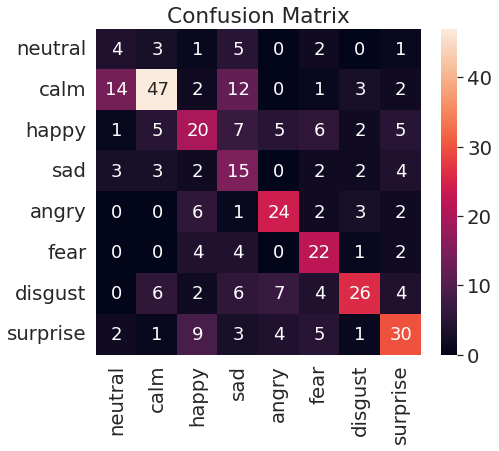

For only_mfcc_data
Accuracy score :  0.5472222222222223
              precision    recall  f1-score   support

           1       0.47      0.29      0.36        24
           2       0.57      0.71      0.63        65
           3       0.43      0.43      0.43        46
           4       0.61      0.42      0.49        53
           5       0.65      0.60      0.62        40
           6       0.63      0.50      0.56        44
           7       0.39      0.58      0.46        38
           8       0.63      0.68      0.65        50

    accuracy                           0.55       360
   macro avg       0.55      0.53      0.53       360
weighted avg       0.56      0.55      0.54       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         7     4      0    4      0     0        0         0
calm           11    46      3   11      1     1        4         3
happy           1     5     20    5      4     7        3         1
sad             4    

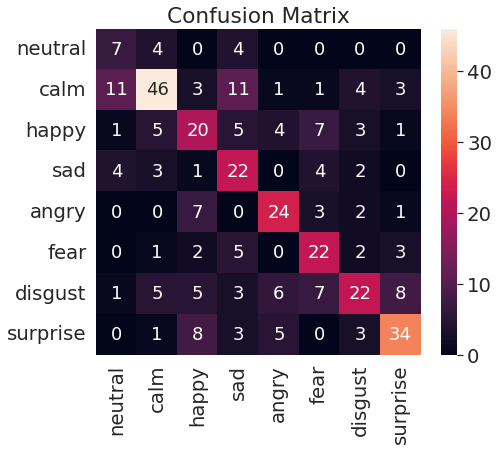

For all_features_data
Accuracy score :  0.5277777777777778
              precision    recall  f1-score   support

           1       0.64      0.38      0.47        24
           2       0.60      0.82      0.69        65
           3       0.45      0.39      0.42        46
           4       0.52      0.42      0.46        53
           5       0.72      0.53      0.61        40
           6       0.50      0.36      0.42        44
           7       0.33      0.55      0.42        38
           8       0.59      0.60      0.59        50

    accuracy                           0.53       360
   macro avg       0.54      0.50      0.51       360
weighted avg       0.54      0.53      0.52       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         9     3      0    1      0     0        0         1
calm            9    53      2   11      0     2        7         5
happy           2     1     18    6      3     3        3         4
sad             3 

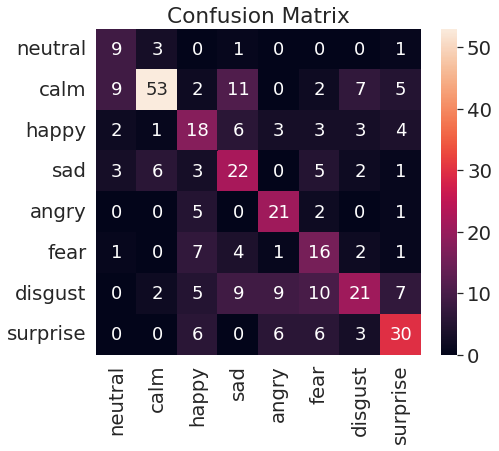

In [50]:
model_2=RandomForestClassifier(random_state=39)
model_classifier(model_2,dataset_dict,"Random ForestClassifier",model_dict)

Ensemble model Xgboost

Model : Xgboost Classifier
For time_domain_data
Accuracy score :  0.2777777777777778
              precision    recall  f1-score   support

           1       0.27      0.25      0.26        24
           2       0.48      0.49      0.49        65
           3       0.12      0.13      0.13        46
           4       0.21      0.15      0.18        53
           5       0.39      0.38      0.38        40
           6       0.27      0.20      0.23        44
           7       0.16      0.32      0.22        38
           8       0.29      0.24      0.26        50

    accuracy                           0.28       360
   macro avg       0.28      0.27      0.27       360
weighted avg       0.29      0.28      0.28       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         6     9      0    5      0     1        1         0
calm            7    32      3   13      1     2        7         1
happy           2     3      6   13      7     5        5   

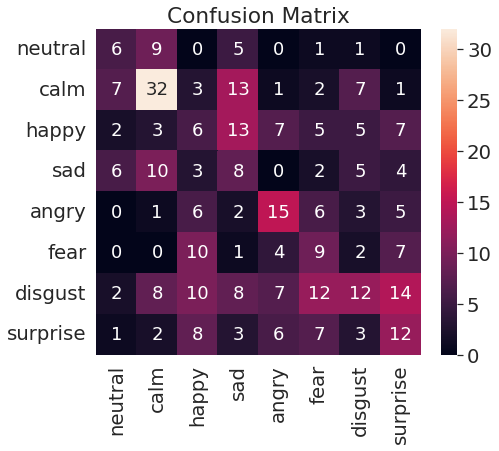

For frequency_domain_data
Accuracy score :  0.4444444444444444
              precision    recall  f1-score   support

           1       0.28      0.21      0.24        24
           2       0.62      0.72      0.67        65
           3       0.35      0.33      0.34        46
           4       0.42      0.38      0.40        53
           5       0.61      0.50      0.55        40
           6       0.40      0.32      0.35        44
           7       0.33      0.47      0.39        38
           8       0.40      0.42      0.41        50

    accuracy                           0.44       360
   macro avg       0.42      0.42      0.42       360
weighted avg       0.44      0.44      0.44       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         5     7      0    4      0     0        1         1
calm            8    47      2    9      0     2        5         3
happy           2     0     15   10      3     7        0         6
sad           

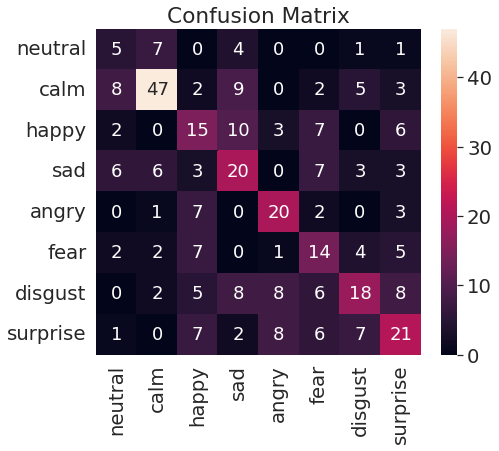

For spectral_domain_data
Accuracy score :  0.49444444444444446
              precision    recall  f1-score   support

           1       0.36      0.38      0.37        24
           2       0.55      0.63      0.59        65
           3       0.31      0.35      0.33        46
           4       0.57      0.38      0.45        53
           5       0.76      0.62      0.68        40
           6       0.54      0.50      0.52        44
           7       0.40      0.55      0.47        38
           8       0.49      0.48      0.48        50

    accuracy                           0.49       360
   macro avg       0.50      0.49      0.49       360
weighted avg       0.51      0.49      0.50       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         9     6      2    5      0     0        1         2
calm           11    41      3   11      0     1        3         4
happy           0     7     16    7      4     8        3         6
sad           

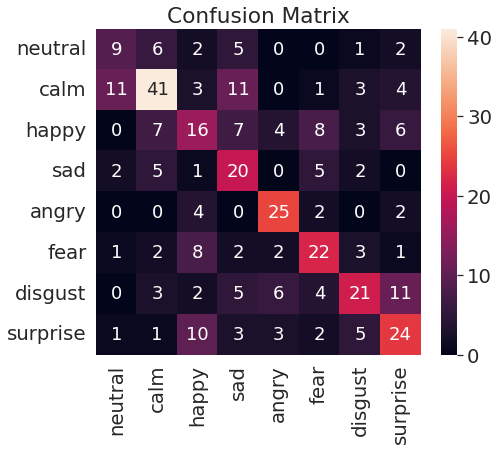

For only_mfcc_data
Accuracy score :  0.49444444444444446
              precision    recall  f1-score   support

           1       0.33      0.25      0.29        24
           2       0.58      0.65      0.61        65
           3       0.43      0.41      0.42        46
           4       0.56      0.38      0.45        53
           5       0.55      0.65      0.60        40
           6       0.50      0.45      0.48        44
           7       0.33      0.50      0.40        38
           8       0.59      0.52      0.55        50

    accuracy                           0.49       360
   macro avg       0.48      0.48      0.47       360
weighted avg       0.50      0.49      0.49       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         6     6      0    5      0     1        0         0
calm           12    42      1   11      0     0        3         4
happy           0     4     19    4      4     5        4         4
sad             3   

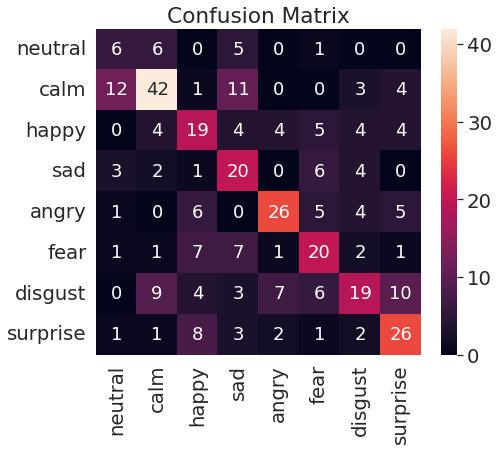

For all_features_data
Accuracy score :  0.5555555555555556
              precision    recall  f1-score   support

           1       0.36      0.38      0.37        24
           2       0.65      0.78      0.71        65
           3       0.44      0.46      0.45        46
           4       0.61      0.51      0.56        53
           5       0.74      0.62      0.68        40
           6       0.57      0.48      0.52        44
           7       0.42      0.58      0.48        38
           8       0.59      0.48      0.53        50

    accuracy                           0.56       360
   macro avg       0.55      0.54      0.54       360
weighted avg       0.56      0.56      0.56       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         9     6      1    8      0     0        0         1
calm            7    51      2    7      0     2        6         3
happy           5     1     21    6      1     6        2         6
sad             2 

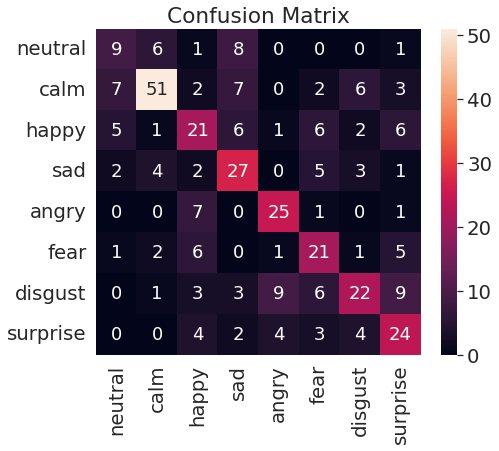

In [51]:
model_3 = xgb.XGBClassifier(random_state=39)
model_classifier(model_3,dataset_dict,"Xgboost Classifier",model_dict)

Ensemble model LightGBM

Model : LGBM Classifier
For time_domain_data
Accuracy score :  0.25555555555555554
              precision    recall  f1-score   support

           1       0.12      0.08      0.10        24
           2       0.41      0.40      0.41        65
           3       0.18      0.20      0.19        46
           4       0.19      0.19      0.19        53
           5       0.47      0.38      0.42        40
           6       0.25      0.27      0.26        44
           7       0.18      0.24      0.20        38
           8       0.20      0.18      0.19        50

    accuracy                           0.26       360
   macro avg       0.25      0.24      0.24       360
weighted avg       0.26      0.26      0.26       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         2     6      0    5      2     2        0         0
calm            8    26      2   14      1     1        7         4
happy           2     3      9    7      9     7        4     

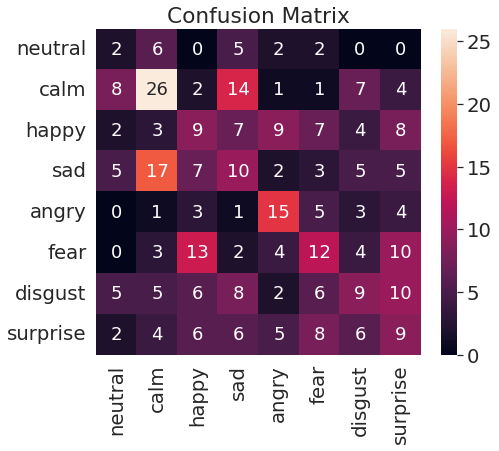

For frequency_domain_data
Accuracy score :  0.5027777777777778
              precision    recall  f1-score   support

           1       0.38      0.21      0.27        24
           2       0.65      0.78      0.71        65
           3       0.37      0.30      0.33        46
           4       0.45      0.43      0.44        53
           5       0.66      0.62      0.64        40
           6       0.55      0.55      0.55        44
           7       0.33      0.45      0.38        38
           8       0.47      0.44      0.45        50

    accuracy                           0.50       360
   macro avg       0.48      0.47      0.47       360
weighted avg       0.50      0.50      0.50       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         5     5      0    3      0     0        0         0
calm            8    51      1   11      0     0        5         2
happy           3     1     14    7      2     3        3         5
sad           

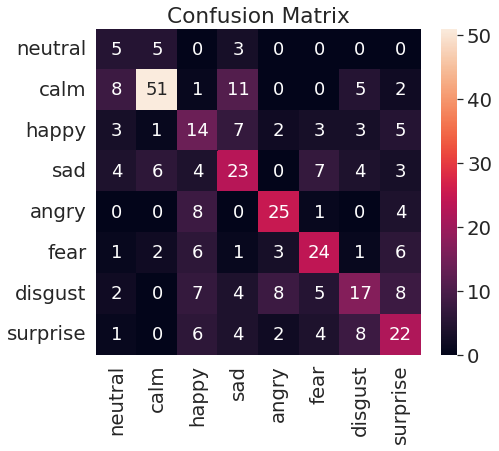

For spectral_domain_data
Accuracy score :  0.6055555555555555
              precision    recall  f1-score   support

           1       0.36      0.38      0.37        24
           2       0.66      0.72      0.69        65
           3       0.47      0.57      0.51        46
           4       0.66      0.47      0.55        53
           5       0.74      0.65      0.69        40
           6       0.63      0.59      0.61        44
           7       0.61      0.79      0.69        38
           8       0.63      0.58      0.60        50

    accuracy                           0.61       360
   macro avg       0.60      0.59      0.59       360
weighted avg       0.61      0.61      0.60       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         9     6      2    5      0     2        0         1
calm           10    47      1    8      0     0        2         3
happy           0     4     26    7      6     5        1         6
sad            

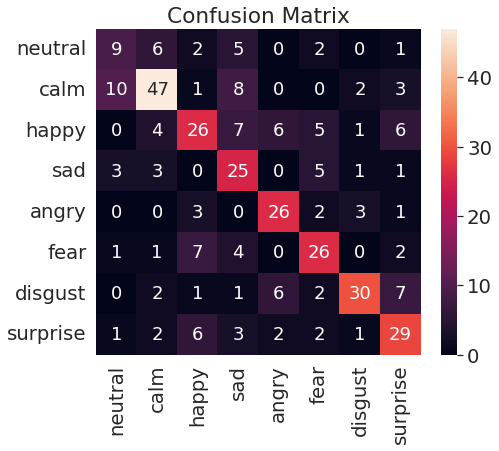

For only_mfcc_data
Accuracy score :  0.5777777777777777
              precision    recall  f1-score   support

           1       0.47      0.38      0.42        24
           2       0.65      0.71      0.68        65
           3       0.57      0.59      0.58        46
           4       0.63      0.45      0.53        53
           5       0.68      0.65      0.67        40
           6       0.52      0.57      0.54        44
           7       0.40      0.63      0.49        38
           8       0.69      0.54      0.61        50

    accuracy                           0.58       360
   macro avg       0.58      0.56      0.56       360
weighted avg       0.59      0.58      0.58       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         9     4      0    6      0     0        0         0
calm           11    46      0    7      0     0        3         4
happy           0     0     27    4      5     4        4         3
sad             2    

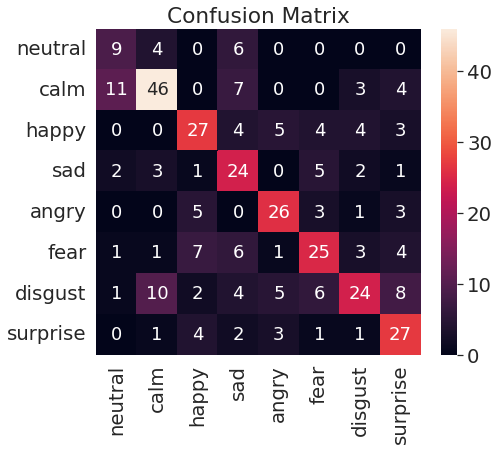

For all_features_data
Accuracy score :  0.5666666666666667
              precision    recall  f1-score   support

           1       0.40      0.33      0.36        24
           2       0.66      0.83      0.73        65
           3       0.41      0.43      0.42        46
           4       0.57      0.49      0.53        53
           5       0.74      0.65      0.69        40
           6       0.68      0.61      0.64        44
           7       0.43      0.55      0.48        38
           8       0.56      0.44      0.49        50

    accuracy                           0.57       360
   macro avg       0.56      0.54      0.54       360
weighted avg       0.57      0.57      0.56       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         8     4      0    4      0     1        1         2
calm            9    54      2   10      0     0        4         3
happy           2     1     20    7      6     2        3         8
sad             3 

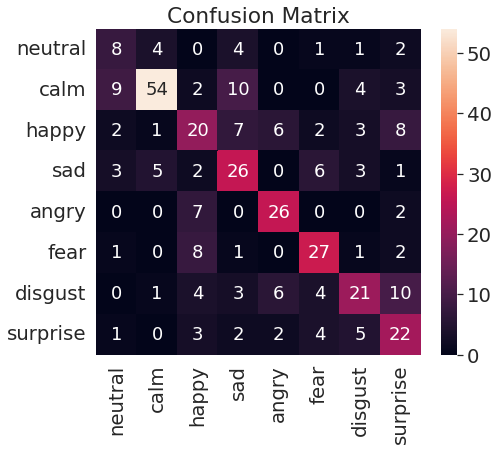

In [52]:
model_4 = LGBMClassifier(random_state=39)
model_classifier(model_4,dataset_dict,"LGBM Classifier",model_dict)

Ensemble model Adaboost

Model : Adaboost Classifier
For time_domain_data
Accuracy score :  0.25555555555555554
              precision    recall  f1-score   support

           1       0.24      0.25      0.24        24
           2       0.49      0.55      0.52        65
           3       0.21      0.20      0.20        46
           4       0.30      0.17      0.22        53
           5       0.09      0.05      0.06        40
           6       0.18      0.36      0.24        44
           7       0.16      0.26      0.20        38
           8       0.31      0.08      0.13        50

    accuracy                           0.26       360
   macro avg       0.25      0.24      0.23       360
weighted avg       0.27      0.26      0.24       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         6     9      1    2      0     3        3         1
calm            8    36      3   15      1     0        6         4
happy           1     5      9    7      2     7        4 

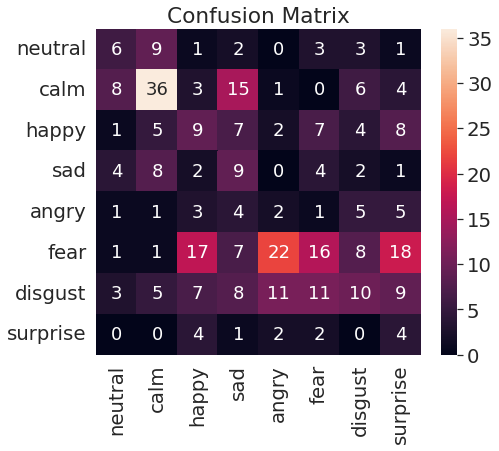

For frequency_domain_data
Accuracy score :  0.28888888888888886
              precision    recall  f1-score   support

           1       0.17      0.38      0.23        24
           2       0.54      0.55      0.55        65
           3       0.08      0.04      0.06        46
           4       0.29      0.19      0.23        53
           5       0.26      0.90      0.40        40
           6       0.12      0.02      0.04        44
           7       0.25      0.11      0.15        38
           8       0.38      0.12      0.18        50

    accuracy                           0.29       360
   macro avg       0.26      0.29      0.23       360
weighted avg       0.28      0.29      0.24       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         9    14      4   11      0     6        5         4
calm            9    36      1   15      0     3        2         1
happy           1     1      2    7      2     5        2         5
sad          

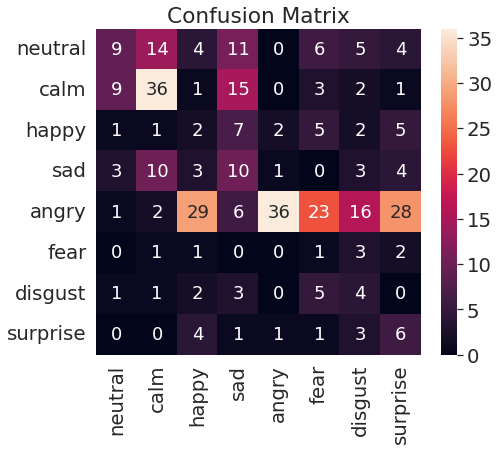

For spectral_domain_data
Accuracy score :  0.275
              precision    recall  f1-score   support

           1       0.17      0.17      0.17        24
           2       0.45      0.40      0.42        65
           3       0.32      0.20      0.24        46
           4       0.23      0.17      0.19        53
           5       0.34      0.70      0.46        40
           6       0.14      0.23      0.18        44
           7       0.24      0.13      0.17        38
           8       0.21      0.16      0.18        50

    accuracy                           0.28       360
   macro avg       0.26      0.27      0.25       360
weighted avg       0.28      0.28      0.26       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         4     8      1    6      0     1        0         4
calm           12    26      2    9      0     1        4         4
happy           2     2      9    0      1     7        3         4
sad             2    16     

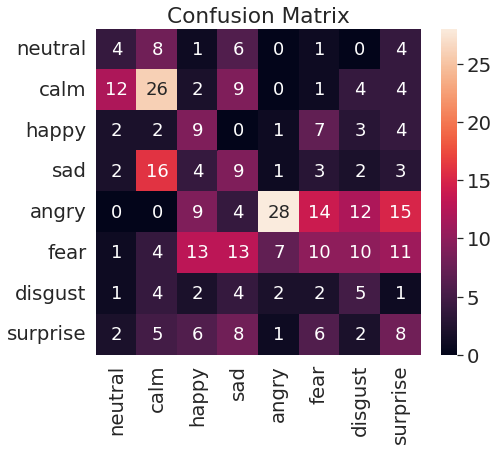

For only_mfcc_data
Accuracy score :  0.2972222222222222
              precision    recall  f1-score   support

           1       0.16      0.12      0.14        24
           2       0.49      0.58      0.54        65
           3       0.14      0.04      0.07        46
           4       0.20      0.17      0.19        53
           5       0.26      0.72      0.38        40
           6       0.20      0.09      0.13        44
           7       0.22      0.21      0.21        38
           8       0.38      0.28      0.32        50

    accuracy                           0.30       360
   macro avg       0.26      0.28      0.25       360
weighted avg       0.28      0.30      0.27       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         3     5      1    5      0     0        2         3
calm           11    38      3   14      1     1        5         4
happy           0     0      2    3      2     3        2         2
sad             5    

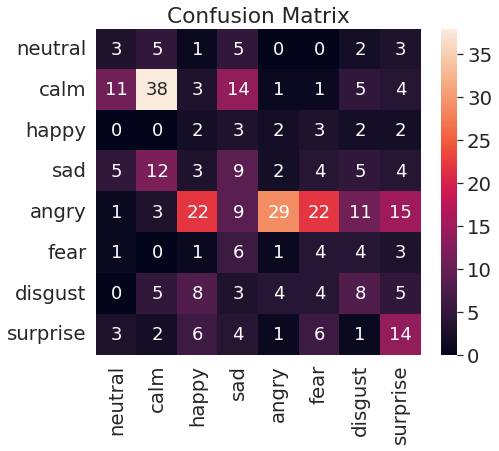

For all_features_data
Accuracy score :  0.2638888888888889
              precision    recall  f1-score   support

           1       0.09      0.17      0.12        24
           2       0.59      0.58      0.59        65
           3       0.00      0.00      0.00        46
           4       0.21      0.17      0.19        53
           5       0.27      0.88      0.41        40
           6       0.15      0.05      0.07        44
           7       0.17      0.08      0.11        38
           8       0.21      0.08      0.12        50

    accuracy                           0.26       360
   macro avg       0.21      0.25      0.20       360
weighted avg       0.24      0.26      0.22       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         4    14      3   12      0     4        3         4
calm            8    38      0   14      0     1        2         1
happy           2     1      0    4      1     6        6         7
sad             6 

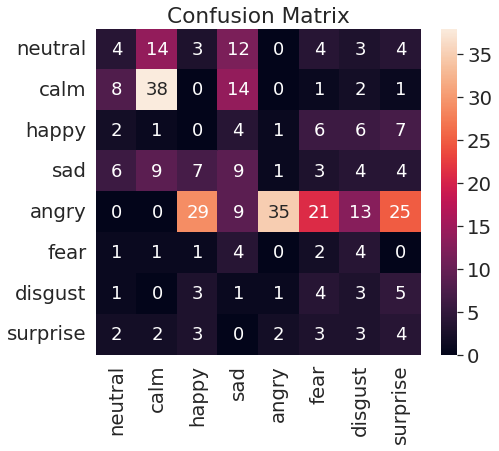

In [53]:
model_5 = AdaBoostClassifier(random_state=39)
model_classifier(model_5,dataset_dict,"Adaboost Classifier",model_dict)

Gaussian Naive bayes

Model : Gaussian naive Bayes Classifier
For time_domain_data
Accuracy score :  0.2972222222222222
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        24
           2       0.39      0.85      0.53        65
           3       0.27      0.09      0.13        46
           4       0.25      0.04      0.07        53
           5       0.65      0.33      0.43        40
           6       0.21      0.14      0.16        44
           7       0.17      0.45      0.25        38
           8       0.32      0.20      0.25        50

    accuracy                           0.30       360
   macro avg       0.28      0.26      0.23       360
weighted avg       0.30      0.30      0.25       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         0     5      2    4      1     2        2         1
calm           21    55      6   27      2     7       13        11
happy           0     0      4    3      2     

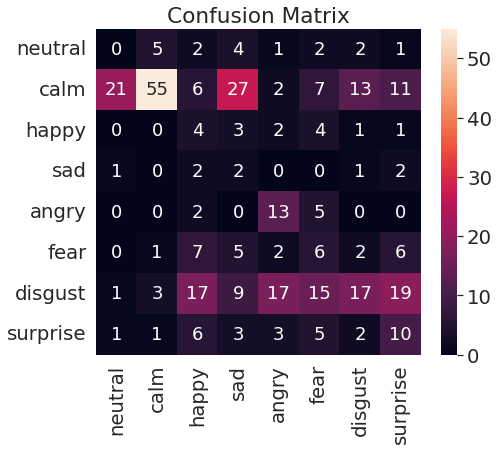

For frequency_domain_data
Accuracy score :  0.2972222222222222
              precision    recall  f1-score   support

           1       0.08      0.12      0.10        24
           2       0.40      0.92      0.56        65
           3       0.31      0.11      0.16        46
           4       0.15      0.19      0.17        53
           5       0.65      0.33      0.43        40
           6       0.36      0.09      0.15        44
           7       0.10      0.05      0.07        38
           8       0.26      0.20      0.23        50

    accuracy                           0.30       360
   macro avg       0.29      0.25      0.23       360
weighted avg       0.30      0.30      0.26       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         3     3      5   10      2     4        6         5
calm           19    60      8   28      1    10       13        10
happy           0     0      5    2      2     4        1         2
sad           

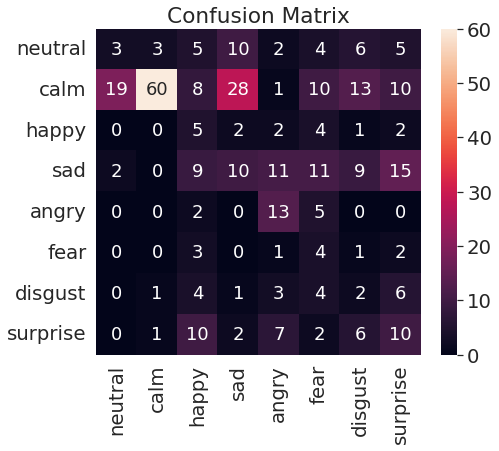

For spectral_domain_data
Accuracy score :  0.25
              precision    recall  f1-score   support

           1       0.10      0.17      0.13        24
           2       0.37      0.52      0.43        65
           3       0.27      0.07      0.11        46
           4       0.00      0.00      0.00        53
           5       0.27      0.45      0.34        40
           6       0.50      0.02      0.04        44
           7       0.25      0.42      0.32        38
           8       0.16      0.28      0.21        50

    accuracy                           0.25       360
   macro avg       0.24      0.24      0.20       360
weighted avg       0.25      0.25      0.20       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         4    13      3   13      0     3        0         3
calm           18    34      4   16      0     4        8         8
happy           0     0      3    4      1     1        1         1
sad             0     0      

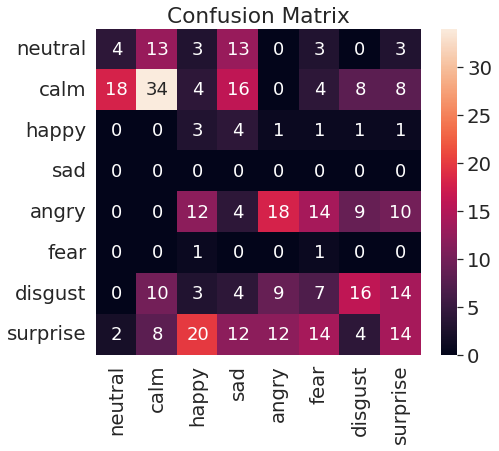

For only_mfcc_data
Accuracy score :  0.32222222222222224
              precision    recall  f1-score   support

           1       0.18      0.42      0.25        24
           2       0.48      0.45      0.46        65
           3       0.17      0.09      0.11        46
           4       0.29      0.15      0.20        53
           5       0.38      0.38      0.38        40
           6       0.38      0.32      0.35        44
           7       0.22      0.32      0.26        38
           8       0.41      0.48      0.44        50

    accuracy                           0.32       360
   macro avg       0.31      0.32      0.31       360
weighted avg       0.33      0.32      0.32       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        10    13      5   10      3     8        6         2
calm            6    29      2   13      1     1        6         2
happy           1     4      4    3      2     4        4         2
sad             3   

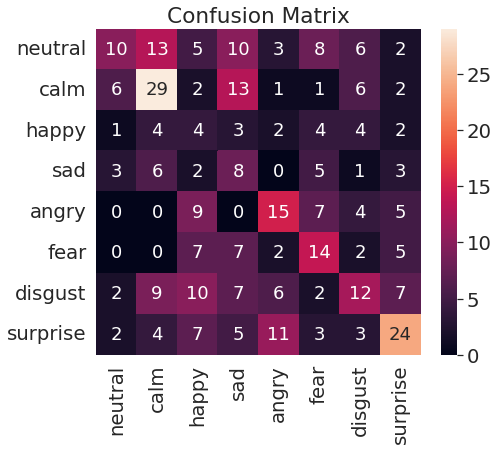

For all_features_data
Accuracy score :  0.275
              precision    recall  f1-score   support

           1       0.10      0.17      0.13        24
           2       0.37      0.52      0.43        65
           3       0.33      0.15      0.21        46
           4       0.00      0.00      0.00        53
           5       0.42      0.40      0.41        40
           6       0.33      0.05      0.08        44
           7       0.29      0.58      0.38        38
           8       0.16      0.28      0.20        50

    accuracy                           0.28       360
   macro avg       0.25      0.27      0.23       360
weighted avg       0.26      0.28      0.24       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         4    13      3   13      0     3        0         3
calm           18    34      4   16      0     4        8         8
happy           0     0      7    5      2     3        2         2
sad             0     0      0 

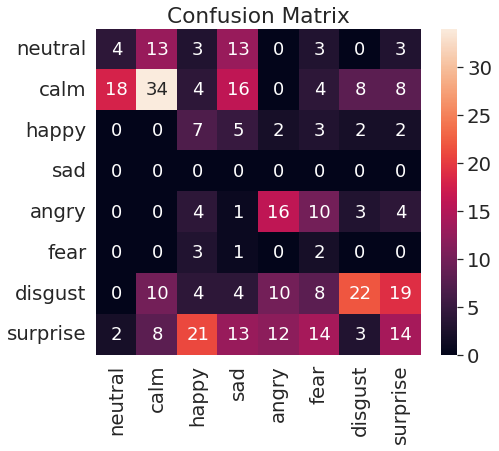

In [54]:
model_6 = GaussianNB()
model_classifier(model_6,dataset_dict,"Gaussian naive Bayes Classifier",model_dict)

Quadratic Discriminant Analysis(QDA)

Model : QDA
For time_domain_data
Accuracy score :  0.3055555555555556
              precision    recall  f1-score   support

           1       0.05      0.04      0.05        24
           2       0.40      0.82      0.53        65
           3       0.23      0.11      0.15        46
           4       0.27      0.06      0.09        53
           5       0.65      0.33      0.43        40
           6       0.32      0.14      0.19        44
           7       0.17      0.45      0.24        38
           8       0.36      0.24      0.29        50

    accuracy                           0.31       360
   macro avg       0.31      0.27      0.25       360
weighted avg       0.32      0.31      0.27       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         1     6      3    3      0     2        3         2
calm           19    53      6   27      2     7       10        10
happy           0     1      5    4      4     4        1         3
sad    

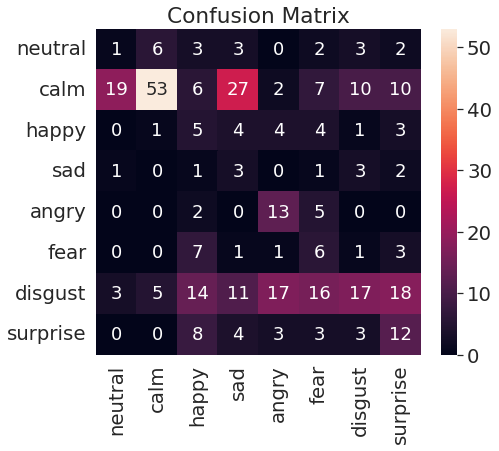

For frequency_domain_data
Accuracy score :  0.14722222222222223
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        24
           2       0.00      0.00      0.00        65
           3       0.50      0.02      0.04        46
           4       0.00      0.00      0.00        53
           5       0.16      1.00      0.27        40
           6       0.28      0.11      0.16        44
           7       0.08      0.18      0.11        38
           8       0.00      0.00      0.00        50

    accuracy                           0.15       360
   macro avg       0.13      0.16      0.07       360
weighted avg       0.12      0.15      0.07       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         0     0      0    0      0     0        0         0
calm            0     0      0    0      0     0        0         0
happy           0     0      1    0      0     0        1         0
sad          

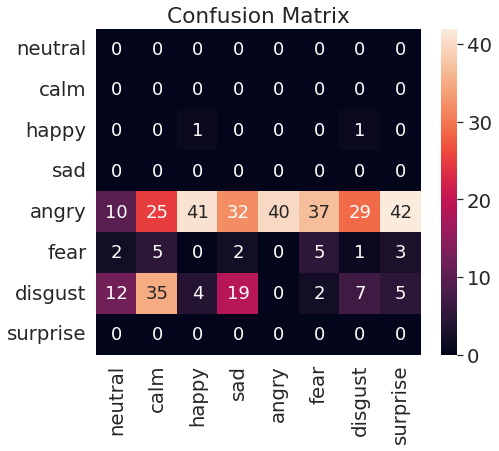

For spectral_domain_data
Accuracy score :  0.5694444444444444
              precision    recall  f1-score   support

           1       0.70      0.29      0.41        24
           2       0.68      0.63      0.66        65
           3       0.47      0.50      0.48        46
           4       0.52      0.53      0.52        53
           5       0.62      0.72      0.67        40
           6       0.48      0.48      0.48        44
           7       0.49      0.66      0.56        38
           8       0.69      0.62      0.65        50

    accuracy                           0.57       360
   macro avg       0.58      0.55      0.55       360
weighted avg       0.58      0.57      0.57       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         7     2      1    0      0     0        0         0
calm           10    41      1    5      0     1        1         1
happy           3     3     23    5      4     6        2         3
sad            

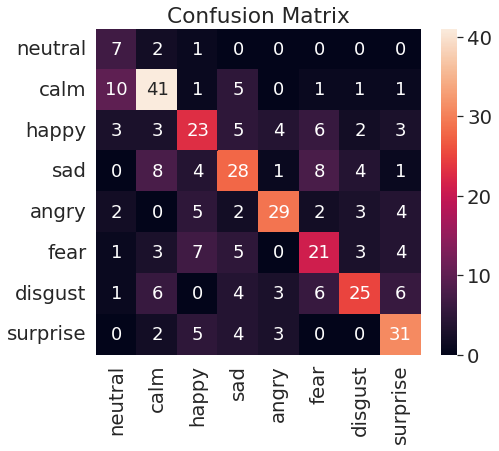

For only_mfcc_data
Accuracy score :  0.5694444444444444
              precision    recall  f1-score   support

           1       0.62      0.33      0.43        24
           2       0.66      0.65      0.65        65
           3       0.50      0.48      0.49        46
           4       0.46      0.43      0.45        53
           5       0.57      0.68      0.62        40
           6       0.57      0.52      0.55        44
           7       0.47      0.74      0.58        38
           8       0.74      0.64      0.69        50

    accuracy                           0.57       360
   macro avg       0.57      0.56      0.56       360
weighted avg       0.58      0.57      0.57       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         8     2      2    1      0     0        0         0
calm            9    42      0    9      0     1        2         1
happy           3     5     22    1      3     4        2         4
sad             1    

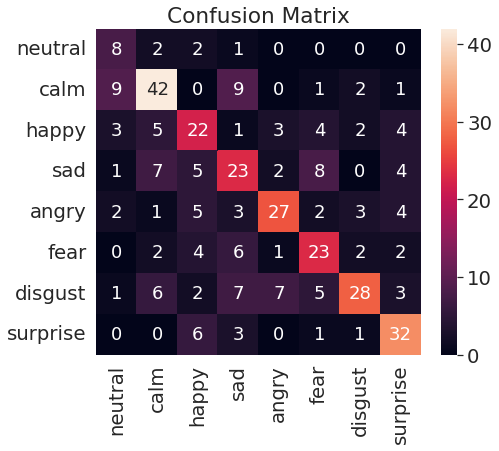

For all_features_data
Accuracy score :  0.19444444444444445
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        24
           2       0.42      0.28      0.33        65
           3       0.15      0.24      0.18        46
           4       0.20      0.25      0.22        53
           5       0.18      0.07      0.11        40
           6       0.15      0.07      0.09        44
           7       0.13      0.37      0.20        38
           8       0.28      0.16      0.20        50

    accuracy                           0.19       360
   macro avg       0.19      0.18      0.17       360
weighted avg       0.21      0.19      0.19       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         0     0      1    3      0     0        0         1
calm            3    18      3    6      2     4        5         2
happy           3     7     11    6     12    16        9        11
sad             7

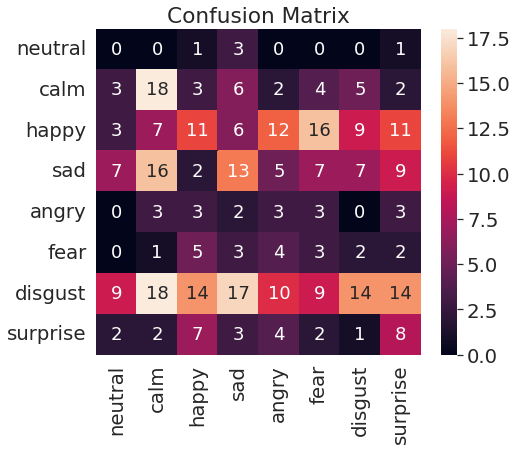

In [55]:
model_7 = QuadraticDiscriminantAnalysis()
model_classifier(model_7,dataset_dict,"QDA",model_dict)

Linear Discriminant Analysis(LDA)

Model : LDA
For time_domain_data
Accuracy score :  0.2388888888888889
              precision    recall  f1-score   support

           1       0.50      0.04      0.08        24
           2       0.40      0.38      0.39        65
           3       0.12      0.07      0.08        46
           4       0.16      0.17      0.16        53
           5       0.50      0.33      0.39        40
           6       0.24      0.18      0.21        44
           7       0.18      0.61      0.28        38
           8       0.17      0.08      0.11        50

    accuracy                           0.24       360
   macro avg       0.28      0.23      0.21       360
weighted avg       0.27      0.24      0.22       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         1     0      0    0      0     1        0         0
calm            4    25      4   17      1     3        1         8
happy           1     1      3    3      3     1        2        11
sad    

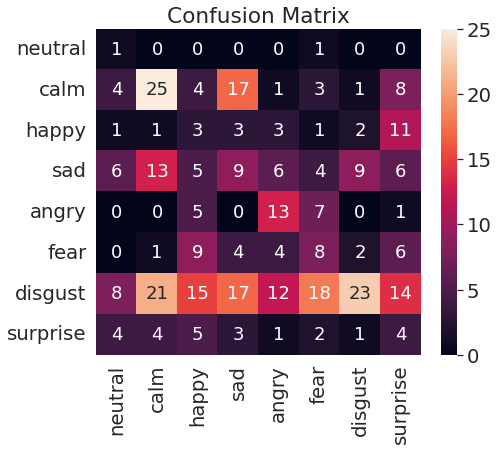

For frequency_domain_data
Accuracy score :  0.3388888888888889
              precision    recall  f1-score   support

           1       0.15      0.12      0.14        24
           2       0.57      0.63      0.60        65
           3       0.18      0.17      0.18        46
           4       0.35      0.32      0.33        53
           5       0.53      0.20      0.29        40
           6       0.36      0.18      0.24        44
           7       0.21      0.39      0.28        38
           8       0.33      0.44      0.38        50

    accuracy                           0.34       360
   macro avg       0.34      0.31      0.30       360
weighted avg       0.36      0.34      0.33       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         3    10      3    2      0     1        0         1
calm            5    41      5   12      1     5        3         0
happy           3     3      8    6      4     5        8         8
sad           

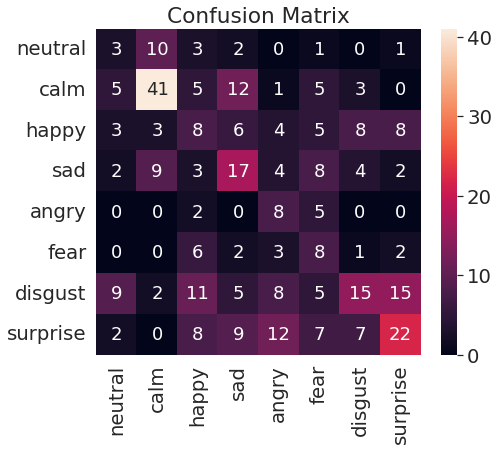

For spectral_domain_data
Accuracy score :  0.46944444444444444
              precision    recall  f1-score   support

           1       0.32      0.33      0.33        24
           2       0.64      0.57      0.60        65
           3       0.34      0.37      0.35        46
           4       0.40      0.34      0.37        53
           5       0.62      0.60      0.61        40
           6       0.50      0.36      0.42        44
           7       0.49      0.63      0.55        38
           8       0.40      0.50      0.45        50

    accuracy                           0.47       360
   macro avg       0.46      0.46      0.46       360
weighted avg       0.48      0.47      0.47       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         8     9      0    6      0     0        0         2
calm            3    37      3    9      0     1        2         3
happy           3     1     17    7      4     8        3         7
sad           

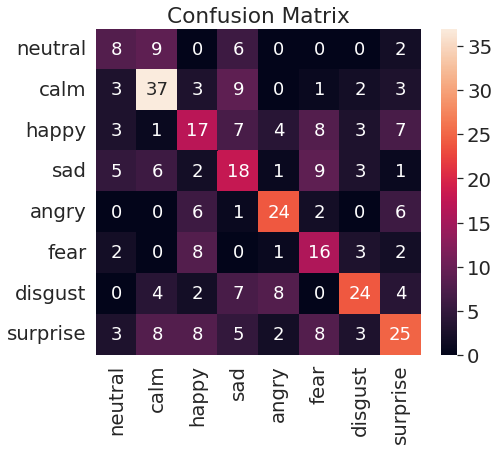

For only_mfcc_data
Accuracy score :  0.41388888888888886
              precision    recall  f1-score   support

           1       0.29      0.17      0.21        24
           2       0.57      0.49      0.53        65
           3       0.34      0.35      0.34        46
           4       0.40      0.38      0.39        53
           5       0.55      0.53      0.54        40
           6       0.46      0.30      0.36        44
           7       0.34      0.58      0.43        38
           8       0.34      0.42      0.38        50

    accuracy                           0.41       360
   macro avg       0.41      0.40      0.40       360
weighted avg       0.43      0.41      0.41       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         4     3      1    4      0     0        0         2
calm            5    32      2    9      0     1        4         3
happy           3     1     16    9      3     7        1         7
sad             8   

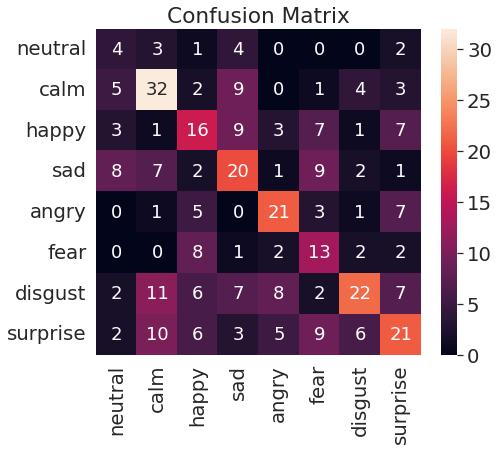

For all_features_data
Accuracy score :  0.4777777777777778
              precision    recall  f1-score   support

           1       0.24      0.38      0.30        24
           2       0.62      0.58      0.60        65
           3       0.38      0.43      0.40        46
           4       0.43      0.40      0.41        53
           5       0.67      0.30      0.41        40
           6       0.58      0.34      0.43        44
           7       0.42      0.63      0.51        38
           8       0.56      0.66      0.61        50

    accuracy                           0.48       360
   macro avg       0.49      0.47      0.46       360
weighted avg       0.51      0.48      0.48       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         9    15      4    5      0     0        1         3
calm            4    38      3   11      0     1        4         0
happy           2     0     20    8      5     9        3         6
sad             7 

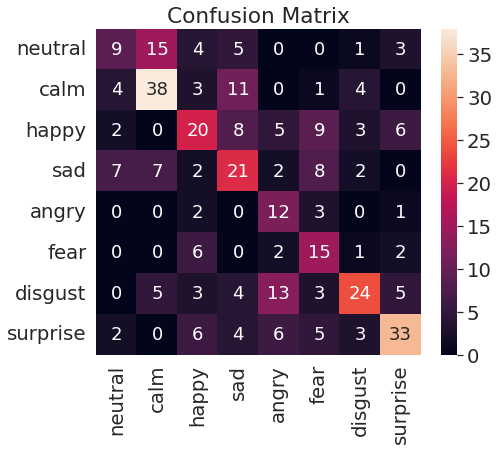

In [56]:
model_8 = LinearDiscriminantAnalysis()
model_classifier(model_8,dataset_dict,"LDA",model_dict)

Multilayer Perceptron Classifier

Model : MLP Classifier
For time_domain_data
Accuracy score :  0.2833333333333333
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        24
           2       0.44      0.69      0.54        65
           3       0.22      0.11      0.14        46
           4       0.19      0.15      0.17        53
           5       0.44      0.35      0.39        40
           6       0.15      0.14      0.14        44
           7       0.17      0.42      0.25        38
           8       0.30      0.16      0.21        50

    accuracy                           0.28       360
   macro avg       0.24      0.25      0.23       360
weighted avg       0.26      0.28      0.26       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         0     0      0    0      0     0        0         0
calm           10    45      5   22      0     5        7         8
happy           0     0      5    3      3     2        4       

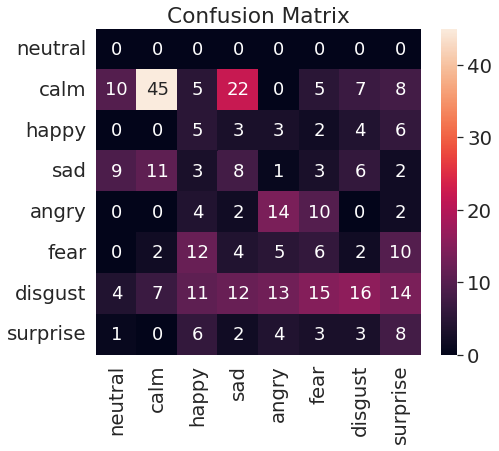

For frequency_domain_data
Accuracy score :  0.3888888888888889
              precision    recall  f1-score   support

           1       0.17      0.12      0.14        24
           2       0.55      0.63      0.59        65
           3       0.25      0.24      0.24        46
           4       0.32      0.26      0.29        53
           5       0.49      0.45      0.47        40
           6       0.40      0.36      0.38        44
           7       0.24      0.34      0.28        38
           8       0.51      0.48      0.49        50

    accuracy                           0.39       360
   macro avg       0.36      0.36      0.36       360
weighted avg       0.39      0.39      0.39       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         3    10      1    1      1     1        0         1
calm            9    41      2   13      0     1        7         2
happy           2     0     11   10      6     7        5         3
sad           

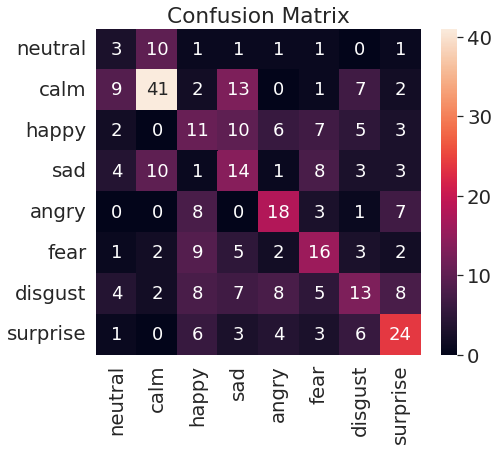

For spectral_domain_data
Accuracy score :  0.15
              precision    recall  f1-score   support

           1       0.18      0.08      0.11        24
           2       0.40      0.09      0.15        65
           3       0.17      0.39      0.24        46
           4       0.00      0.00      0.00        53
           5       0.14      0.07      0.10        40
           6       0.00      0.00      0.00        44
           7       0.00      0.00      0.00        38
           8       0.12      0.50      0.19        50

    accuracy                           0.15       360
   macro avg       0.13      0.14      0.10       360
weighted avg       0.14      0.15      0.10       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         2     4      0    4      0     1        0         0
calm            3     6      1    4      0     0        0         1
happy           3     5     18   12     20    18        6        22
sad             0     0      

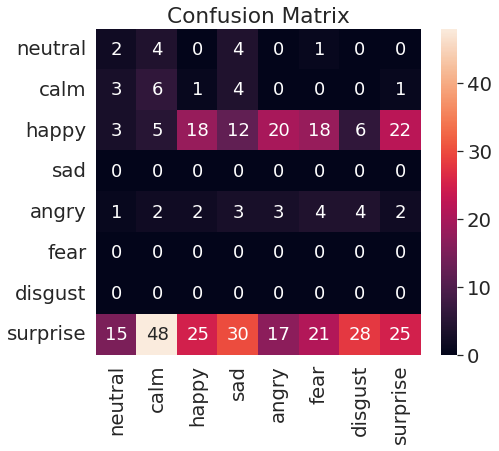

For only_mfcc_data
Accuracy score :  0.45555555555555555
              precision    recall  f1-score   support

           1       0.24      0.42      0.31        24
           2       0.86      0.46      0.60        65
           3       0.35      0.50      0.41        46
           4       0.35      0.23      0.28        53
           5       0.69      0.55      0.61        40
           6       0.53      0.48      0.50        44
           7       0.36      0.53      0.43        38
           8       0.45      0.52      0.48        50

    accuracy                           0.46       360
   macro avg       0.48      0.46      0.45       360
weighted avg       0.51      0.46      0.46       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        10    11      2   12      0     2        0         4
calm            1    30      0    3      0     0        1         0
happy           6     2     23   15      4     8        2         5
sad             1   

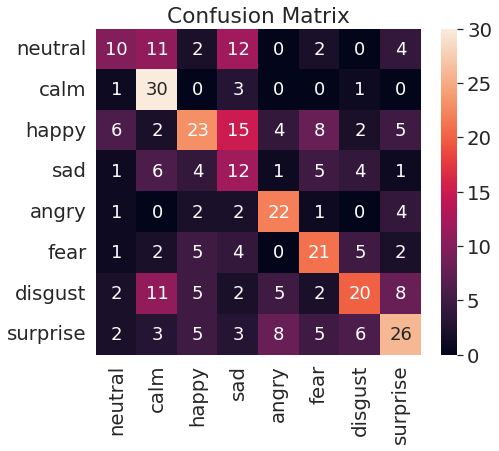

For all_features_data
Accuracy score :  0.15
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        24
           2       0.50      0.12      0.20        65
           3       0.14      0.93      0.24        46
           4       0.00      0.00      0.00        53
           5       0.00      0.00      0.00        40
           6       0.00      0.00      0.00        44
           7       0.00      0.00      0.00        38
           8       0.09      0.06      0.07        50

    accuracy                           0.15       360
   macro avg       0.09      0.14      0.06       360
weighted avg       0.12      0.15      0.08       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         0     0      0    0      0     0        0         0
calm            3     8      0    4      0     0        0         1
happy          18    48     43   38     40    42       36        46
sad             1     0      0  

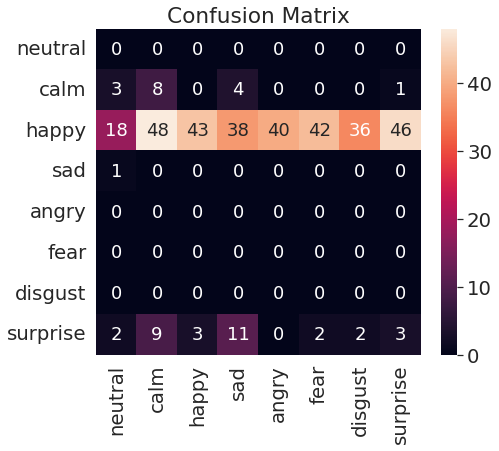

In [57]:
model_9 = MLPClassifier(random_state=39, max_iter=1000)
model_classifier(model_9,dataset_dict,"MLP Classifier",model_dict)

KNN Classifier

Model : KNN
For time_domain_data
Accuracy score :  0.21666666666666667
              precision    recall  f1-score   support

           1       0.07      0.12      0.09        24
           2       0.33      0.31      0.32        65
           3       0.13      0.15      0.14        46
           4       0.18      0.17      0.18        53
           5       0.48      0.33      0.39        40
           6       0.27      0.23      0.25        44
           7       0.10      0.13      0.11        38
           8       0.26      0.22      0.24        50

    accuracy                           0.22       360
   macro avg       0.23      0.21      0.21       360
weighted avg       0.24      0.22      0.23       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         3    11      2   10      0     6        4         5
calm            5    20      5   16      2     1        7         5
happy           4     6      7    3      6     9        7        11
sad   

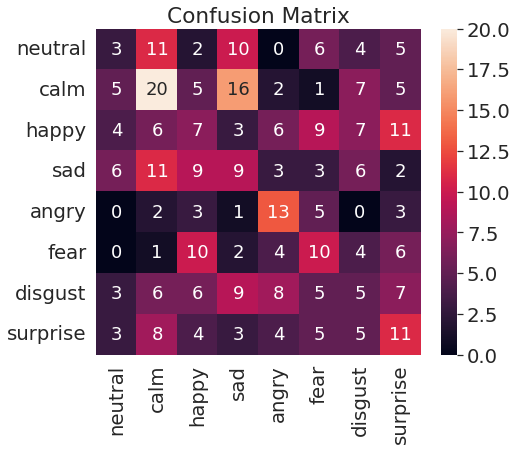

For frequency_domain_data
Accuracy score :  0.4027777777777778
              precision    recall  f1-score   support

           1       0.37      0.54      0.44        24
           2       0.59      0.66      0.62        65
           3       0.27      0.26      0.26        46
           4       0.24      0.23      0.23        53
           5       0.44      0.35      0.39        40
           6       0.45      0.30      0.36        44
           7       0.28      0.37      0.32        38
           8       0.52      0.48      0.50        50

    accuracy                           0.40       360
   macro avg       0.39      0.40      0.39       360
weighted avg       0.41      0.40      0.40       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        13     5      3    6      2     1        3         2
calm            4    43      1   17      0     1        5         2
happy           0     3     12    5      7    10        4         4
sad           

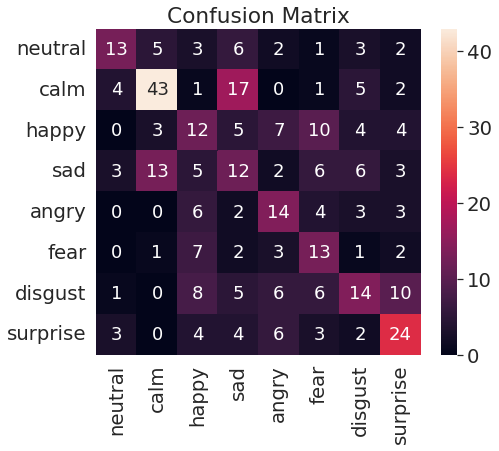

For spectral_domain_data
Accuracy score :  0.2361111111111111
              precision    recall  f1-score   support

           1       0.12      0.25      0.17        24
           2       0.39      0.45      0.42        65
           3       0.23      0.28      0.25        46
           4       0.13      0.08      0.10        53
           5       0.26      0.28      0.27        40
           6       0.18      0.14      0.16        44
           7       0.22      0.24      0.23        38
           8       0.21      0.14      0.17        50

    accuracy                           0.24       360
   macro avg       0.22      0.23      0.22       360
weighted avg       0.23      0.24      0.23       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         6    15      2   15      0     4        2         4
calm            7    29      8   12      2     8        5         3
happy           5     1     13    7      3    11       10         7
sad            

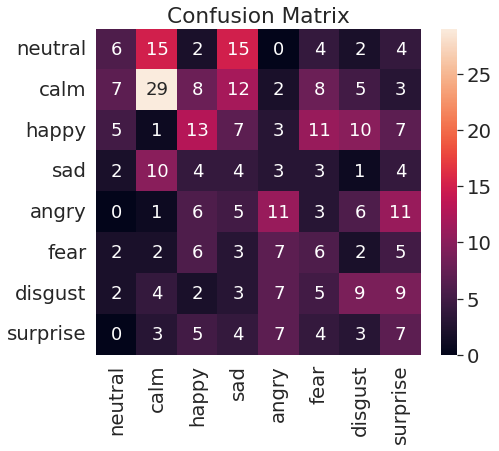

For only_mfcc_data
Accuracy score :  0.36666666666666664
              precision    recall  f1-score   support

           1       0.23      0.38      0.28        24
           2       0.55      0.63      0.59        65
           3       0.31      0.26      0.28        46
           4       0.30      0.19      0.23        53
           5       0.35      0.57      0.43        40
           6       0.44      0.32      0.37        44
           7       0.21      0.21      0.21        38
           8       0.41      0.30      0.34        50

    accuracy                           0.37       360
   macro avg       0.35      0.36      0.34       360
weighted avg       0.37      0.37      0.36       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         9    11      3   10      1     3        1         2
calm           11    41      1   11      0     1        5         4
happy           0     3     12    6      4     6        3         5
sad             4   

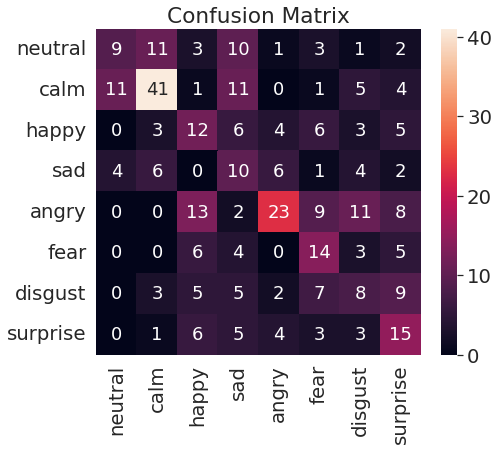

For all_features_data
Accuracy score :  0.2361111111111111
              precision    recall  f1-score   support

           1       0.12      0.25      0.17        24
           2       0.39      0.45      0.42        65
           3       0.23      0.28      0.25        46
           4       0.13      0.08      0.10        53
           5       0.26      0.28      0.27        40
           6       0.18      0.14      0.16        44
           7       0.22      0.24      0.23        38
           8       0.21      0.14      0.17        50

    accuracy                           0.24       360
   macro avg       0.22      0.23      0.22       360
weighted avg       0.23      0.24      0.23       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         6    15      2   15      0     4        2         4
calm            7    29      8   12      2     8        5         3
happy           5     1     13    7      3    11       10         7
sad             2 

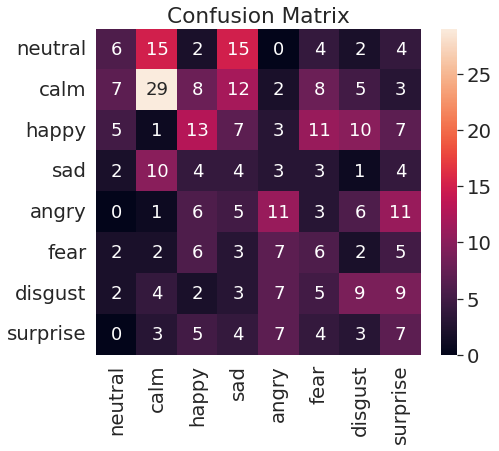

In [58]:
model_10 = KNeighborsClassifier()
model_classifier(model_10,dataset_dict,"KNN",model_dict)

SVC

Model : SVC
For time_domain_data
Accuracy score :  0.28055555555555556
              precision    recall  f1-score   support

           1       0.17      0.08      0.11        24
           2       0.48      0.62      0.54        65
           3       0.16      0.17      0.16        46
           4       0.12      0.09      0.11        53
           5       0.65      0.33      0.43        40
           6       0.22      0.09      0.13        44
           7       0.16      0.45      0.24        38
           8       0.39      0.24      0.30        50

    accuracy                           0.28       360
   macro avg       0.29      0.26      0.25       360
weighted avg       0.31      0.28      0.27       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         2     5      0    3      0     1        1         0
calm            8    40      3   18      0     1        7         6
happy           1     2      8    7      7    12        6         8
sad   

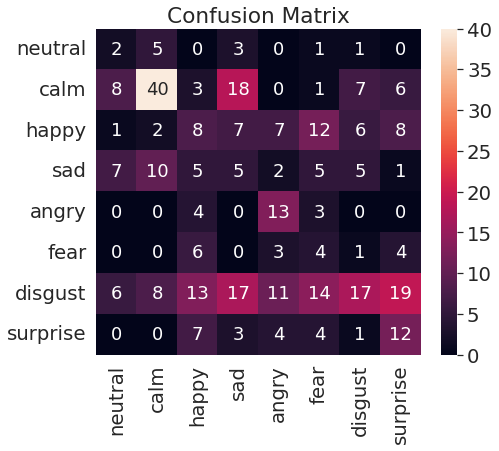

For frequency_domain_data
Accuracy score :  0.3611111111111111
              precision    recall  f1-score   support

           1       0.21      0.25      0.23        24
           2       0.51      0.62      0.56        65
           3       0.33      0.33      0.33        46
           4       0.27      0.32      0.30        53
           5       0.33      0.28      0.30        40
           6       0.41      0.36      0.39        44
           7       0.24      0.24      0.24        38
           8       0.43      0.32      0.37        50

    accuracy                           0.36       360
   macro avg       0.34      0.34      0.34       360
weighted avg       0.36      0.36      0.36       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         6    12      2    4      0     1        2         1
calm            5    40      4   13      7     3        4         3
happy           1     0     15    3      4     8        6         8
sad           

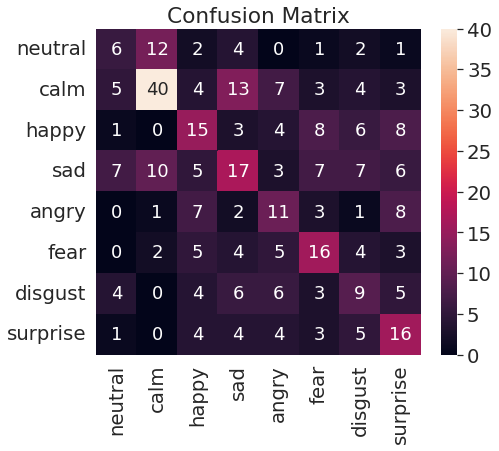

For spectral_domain_data
Accuracy score :  0.25
              precision    recall  f1-score   support

           1       0.33      0.04      0.07        24
           2       0.29      0.62      0.39        65
           3       0.12      0.04      0.06        46
           4       0.19      0.08      0.11        53
           5       0.27      0.42      0.33        40
           6       0.19      0.09      0.12        44
           7       0.22      0.50      0.31        38
           8       0.25      0.06      0.10        50

    accuracy                           0.25       360
   macro avg       0.23      0.23      0.19       360
weighted avg       0.23      0.25      0.20       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         1     2      0    0      0     0        0         0
calm           19    40     17   30      3    11        6        12
happy           1     1      2    5      2     3        1         2
sad             2    10      

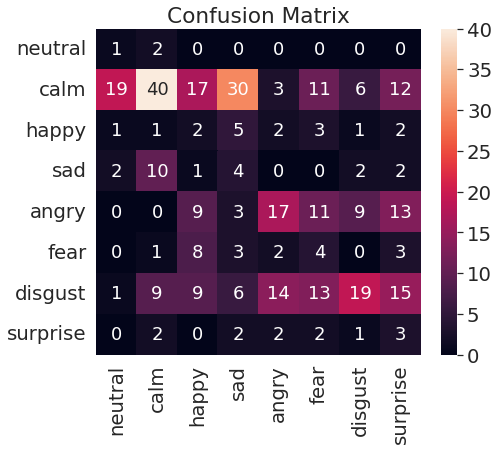

For only_mfcc_data
Accuracy score :  0.5166666666666667
              precision    recall  f1-score   support

           1       0.33      0.54      0.41        24
           2       0.62      0.57      0.59        65
           3       0.46      0.50      0.48        46
           4       0.47      0.47      0.47        53
           5       0.62      0.60      0.61        40
           6       0.67      0.45      0.54        44
           7       0.41      0.45      0.43        38
           8       0.56      0.54      0.55        50

    accuracy                           0.52       360
   macro avg       0.52      0.52      0.51       360
weighted avg       0.53      0.52      0.52       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        13     9      2    7      0     2        1         5
calm            5    37      2    9      1     0        4         2
happy           0     0     23    6      4     9        1         7
sad             5    

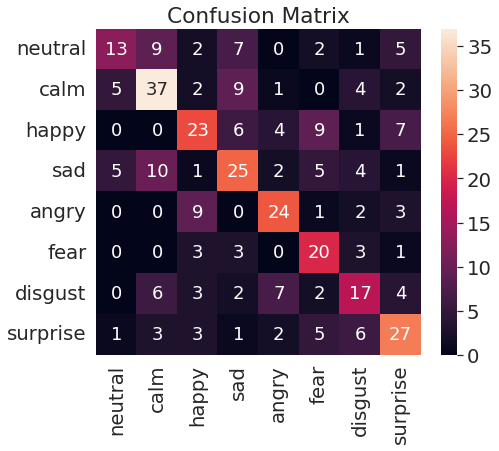

For all_features_data
Accuracy score :  0.25277777777777777
              precision    recall  f1-score   support

           1       0.50      0.04      0.08        24
           2       0.30      0.65      0.41        65
           3       0.12      0.04      0.06        46
           4       0.19      0.08      0.11        53
           5       0.27      0.42      0.33        40
           6       0.21      0.09      0.13        44
           7       0.22      0.50      0.30        38
           8       0.18      0.04      0.07        50

    accuracy                           0.25       360
   macro avg       0.25      0.23      0.19       360
weighted avg       0.24      0.25      0.20       360

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         1     1      0    0      0     0        0         0
calm           19    42     17   30      3    11        6        13
happy           1     1      2    5      2     3        1         1
sad             2

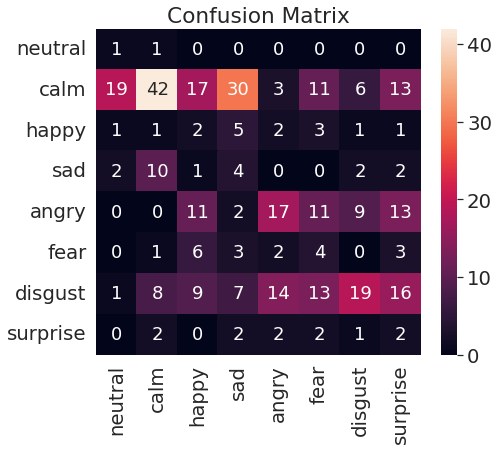

In [100]:
model_11 = SVC(random_state=39,C=10000)
model_classifier(model_11,dataset_dict,"SVC",model_dict)

# AUGMENTATION & SCALING

Decision Tree

Model : Decision Tree Classifier
For time_domain_data
Accuracy score :  0.45416666666666666
              precision    recall  f1-score   support

           1       0.30      0.34      0.32        80
           2       0.62      0.57      0.59       208
           3       0.37      0.35      0.36       198
           4       0.45      0.42      0.44       202
           5       0.49      0.59      0.53       179
           6       0.46      0.40      0.43       212
           7       0.45      0.53      0.49       170
           8       0.41      0.39      0.40       191

    accuracy                           0.45      1440
   macro avg       0.44      0.45      0.44      1440
weighted avg       0.46      0.45      0.45      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        27    19      4   14      1     6        9        11
calm           13   118     11   23      0     7        9         8
happy           7     6     70   24     19    23     

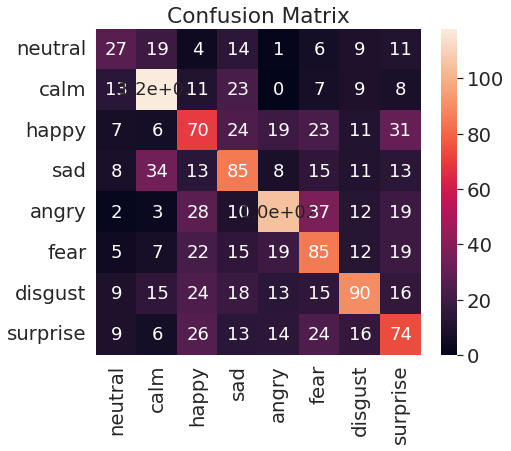

For frequency_domain_data
Accuracy score :  0.80625
              precision    recall  f1-score   support

           1       0.76      0.70      0.73        80
           2       0.89      0.87      0.88       208
           3       0.80      0.78      0.79       198
           4       0.77      0.77      0.77       202
           5       0.88      0.84      0.86       179
           6       0.79      0.85      0.82       212
           7       0.72      0.82      0.76       170
           8       0.83      0.76      0.79       191

    accuracy                           0.81      1440
   macro avg       0.80      0.80      0.80      1440
weighted avg       0.81      0.81      0.81      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        56     4      3    6      0     3        1         1
calm            6   180      0   11      0     3        2         1
happy           5     0    155    3      7     5        8        10
sad             4    13  

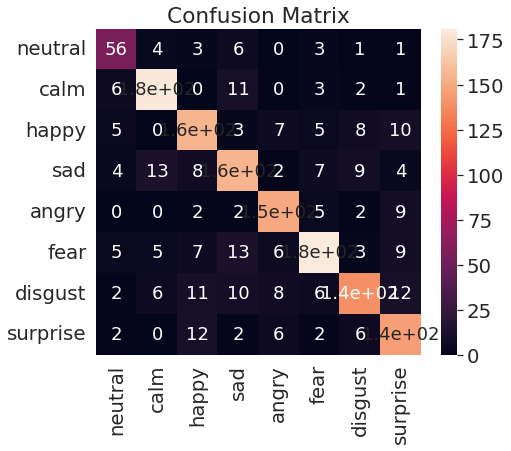

For spectral_domain_data
Accuracy score :  0.5965277777777778
              precision    recall  f1-score   support

           1       0.36      0.36      0.36        80
           2       0.73      0.65      0.69       208
           3       0.57      0.62      0.59       198
           4       0.55      0.53      0.54       202
           5       0.63      0.60      0.61       179
           6       0.65      0.63      0.64       212
           7       0.56      0.67      0.61       170
           8       0.61      0.59      0.60       191

    accuracy                           0.60      1440
   macro avg       0.58      0.58      0.58      1440
weighted avg       0.60      0.60      0.60      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        29    18      6   14      1     7        4         2
calm           18   135      1   14      4     4        6         3
happy           6     8    122   18     15    16        8        22
sad            

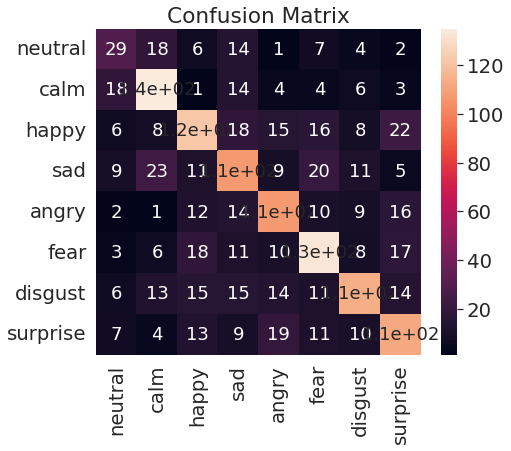

For only_mfcc_data
Accuracy score :  0.6395833333333333
              precision    recall  f1-score   support

           1       0.47      0.62      0.53        80
           2       0.78      0.73      0.75       208
           3       0.62      0.65      0.64       198
           4       0.63      0.55      0.59       202
           5       0.65      0.70      0.67       179
           6       0.67      0.66      0.66       212
           7       0.56      0.61      0.59       170
           8       0.66      0.59      0.62       191

    accuracy                           0.64      1440
   macro avg       0.63      0.64      0.63      1440
weighted avg       0.65      0.64      0.64      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        50    10      5   15      5     6        5        11
calm            5   151      4   18      2     3        9         1
happy           5    11    128   14      6    14        7        20
sad             5    

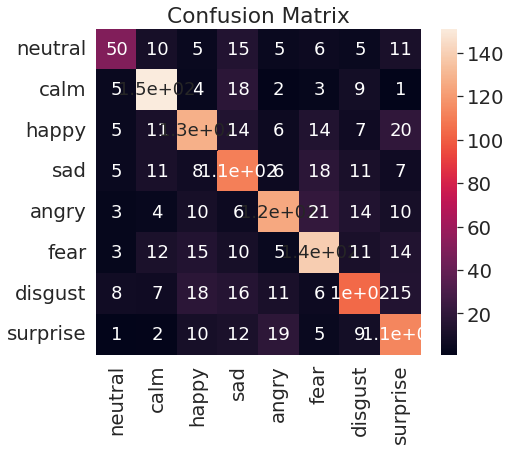

For all_features_data
Accuracy score :  0.7590277777777777
              precision    recall  f1-score   support

           1       0.61      0.68      0.64        80
           2       0.83      0.80      0.81       208
           3       0.75      0.74      0.74       198
           4       0.74      0.73      0.73       202
           5       0.85      0.84      0.85       179
           6       0.78      0.78      0.78       212
           7       0.69      0.72      0.70       170
           8       0.74      0.74      0.74       191

    accuracy                           0.76      1440
   macro avg       0.75      0.75      0.75      1440
weighted avg       0.76      0.76      0.76      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        54    10      2   10      1     3        3         5
calm            9   166      2   15      0     5        3         0
happy           3     0    147   10      5    10       10        12
sad             6 

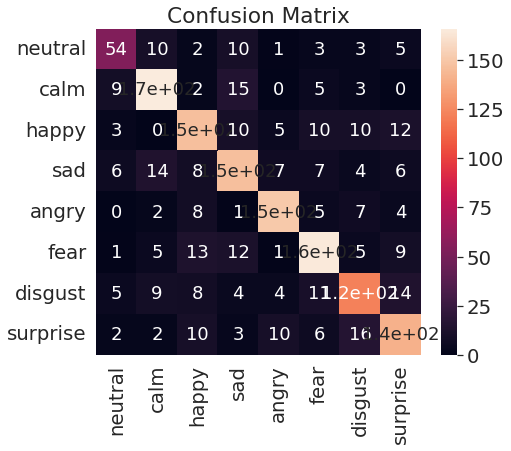

In [60]:
model_aug1=DecisionTreeClassifier(random_state=39)
model_classifier(model_aug1,aug_dict,"Decision Tree Classifier",aug_model_dict)

Random Forest

Model : Random ForestClassifier
For time_domain_data
Accuracy score :  0.5076388888888889
              precision    recall  f1-score   support

           1       0.34      0.38      0.36        80
           2       0.60      0.70      0.65       208
           3       0.44      0.46      0.45       198
           4       0.55      0.40      0.46       202
           5       0.59      0.53      0.56       179
           6       0.55      0.42      0.47       212
           7       0.51      0.60      0.55       170
           8       0.42      0.51      0.46       191

    accuracy                           0.51      1440
   macro avg       0.50      0.50      0.50      1440
weighted avg       0.51      0.51      0.51      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        30    17      2   11      1    10       10         7
calm           17   146     10   40      4     6        8        11
happy           5     8     91   24     20    20       

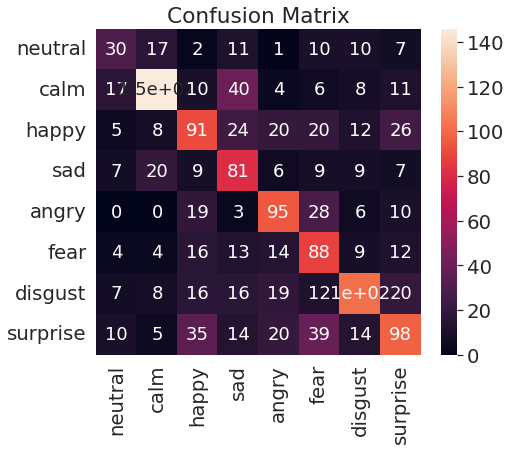

For frequency_domain_data
Accuracy score :  0.9854166666666667
              precision    recall  f1-score   support

           1       1.00      0.95      0.97        80
           2       0.99      1.00      1.00       208
           3       0.99      1.00      0.99       198
           4       0.99      1.00      1.00       202
           5       0.98      0.98      0.98       179
           6       1.00      0.98      0.99       212
           7       0.98      0.99      0.98       170
           8       0.97      0.96      0.97       191

    accuracy                           0.99      1440
   macro avg       0.99      0.98      0.98      1440
weighted avg       0.99      0.99      0.99      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        76     0      0    0      0     0        0         0
calm            2   208      0    0      0     0        0         0
happy           0     0    198    0      0     0        0         3
sad           

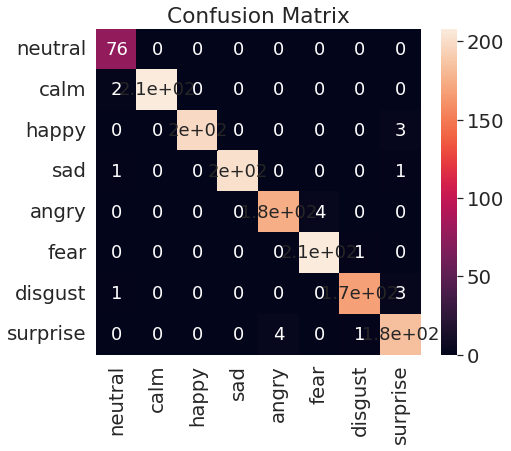

For spectral_domain_data
Accuracy score :  0.8881944444444444
              precision    recall  f1-score   support

           1       0.92      0.71      0.80        80
           2       0.85      0.97      0.91       208
           3       0.89      0.87      0.88       198
           4       0.92      0.91      0.91       202
           5       0.90      0.85      0.87       179
           6       0.96      0.91      0.93       212
           7       0.84      0.91      0.87       170
           8       0.86      0.86      0.86       191

    accuracy                           0.89      1440
   macro avg       0.89      0.87      0.88      1440
weighted avg       0.89      0.89      0.89      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        57     3      0    1      0     1        0         0
calm           12   202      3   11      4     1        4         1
happy           4     0    173    0      2     3        1        11
sad            

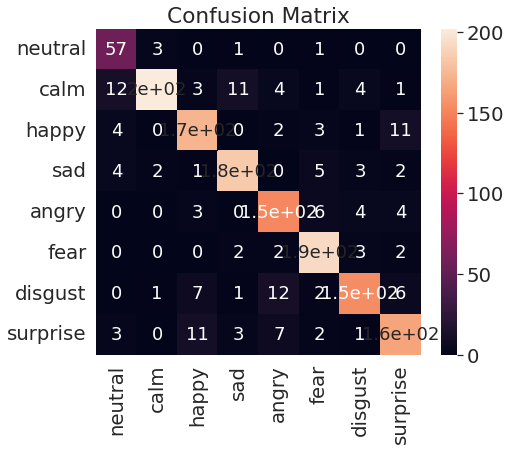

For only_mfcc_data
Accuracy score :  0.9243055555555556
              precision    recall  f1-score   support

           1       0.94      0.81      0.87        80
           2       0.90      0.99      0.94       208
           3       0.95      0.91      0.93       198
           4       0.96      0.92      0.94       202
           5       0.93      0.90      0.91       179
           6       0.96      0.93      0.95       212
           7       0.89      0.95      0.92       170
           8       0.88      0.91      0.89       191

    accuracy                           0.92      1440
   macro avg       0.93      0.92      0.92      1440
weighted avg       0.93      0.92      0.92      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        65     1      0    0      0     2        0         1
calm            7   206      2    8      3     1        1         0
happy           1     0    180    1      0     1        1         6
sad             0    

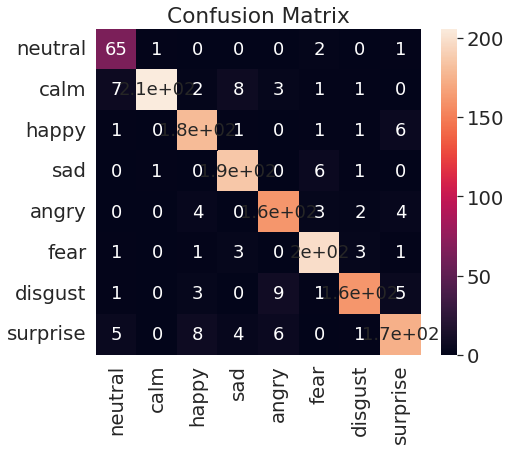

For all_features_data
Accuracy score :  0.98125
              precision    recall  f1-score   support

           1       1.00      0.94      0.97        80
           2       0.99      1.00      0.99       208
           3       0.97      0.98      0.97       198
           4       1.00      1.00      1.00       202
           5       0.98      0.97      0.98       179
           6       0.99      0.98      0.99       212
           7       0.97      0.99      0.98       170
           8       0.96      0.96      0.96       191

    accuracy                           0.98      1440
   macro avg       0.98      0.98      0.98      1440
weighted avg       0.98      0.98      0.98      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        75     0      0    0      0     0        0         0
calm            2   208      1    0      0     0        0         0
happy           3     0    194    0      0     0        0         3
sad             0     0      

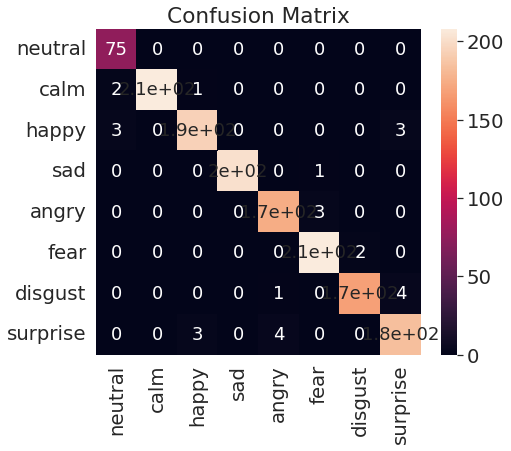

In [61]:
model_aug2=RandomForestClassifier(random_state=39)
model_classifier(model_aug2,aug_dict,"Random ForestClassifier",aug_model_dict)

In [62]:
model_c = RandomForestClassifier(random_state=39)
model_c = model_c.fit(aug_dict["all_features_data"][0],aug_dict["all_features_data"][2])
pickle.dump(model_c,open('classifier.pkl','wb'))

Ensemble model Xgboost

Model : Xgboost Classifier
For time_domain_data
Accuracy score :  0.4027777777777778
              precision    recall  f1-score   support

           1       0.40      0.31      0.35        80
           2       0.49      0.68      0.57       208
           3       0.32      0.37      0.34       198
           4       0.37      0.16      0.22       202
           5       0.51      0.40      0.45       179
           6       0.50      0.25      0.34       212
           7       0.35      0.47      0.40       170
           8       0.34      0.54      0.42       191

    accuracy                           0.40      1440
   macro avg       0.41      0.40      0.39      1440
weighted avg       0.41      0.40      0.39      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        25    11      1    9      1     4        4         7
calm           25   142      9   64      5    11       20        14
happy           9    19     73   33     24    32       15   

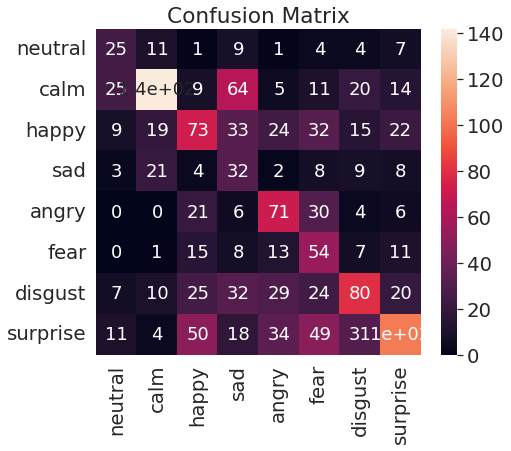

For frequency_domain_data
Accuracy score :  0.81875
              precision    recall  f1-score   support

           1       0.79      0.71      0.75        80
           2       0.85      0.93      0.89       208
           3       0.81      0.77      0.79       198
           4       0.90      0.78      0.84       202
           5       0.88      0.85      0.87       179
           6       0.93      0.80      0.86       212
           7       0.68      0.81      0.74       170
           8       0.72      0.83      0.77       191

    accuracy                           0.82      1440
   macro avg       0.82      0.81      0.81      1440
weighted avg       0.83      0.82      0.82      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        57     3      2    3      1     1        2         3
calm            9   193      3   14      1     1        3         3
happy           7     2    152    9      3     4        8         3
sad             3     6  

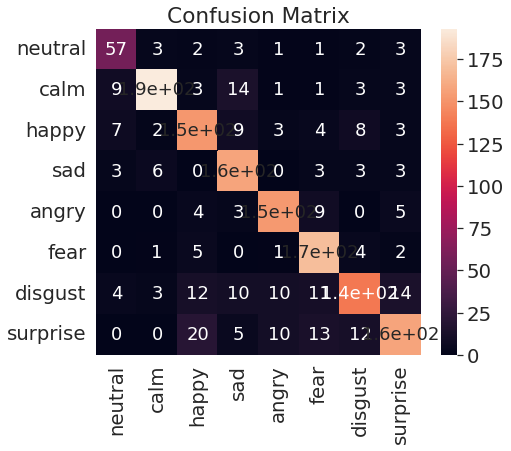

For spectral_domain_data
Accuracy score :  0.6847222222222222
              precision    recall  f1-score   support

           1       0.62      0.46      0.53        80
           2       0.74      0.87      0.80       208
           3       0.65      0.55      0.60       198
           4       0.65      0.65      0.65       202
           5       0.79      0.70      0.74       179
           6       0.80      0.62      0.70       212
           7       0.58      0.74      0.65       170
           8       0.64      0.76      0.70       191

    accuracy                           0.68      1440
   macro avg       0.68      0.67      0.67      1440
weighted avg       0.69      0.68      0.68      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        37     7      1    7      1     4        0         3
calm           16   181      5   24      3     5        8         3
happy           3     3    109    6      6    23        6        11
sad            

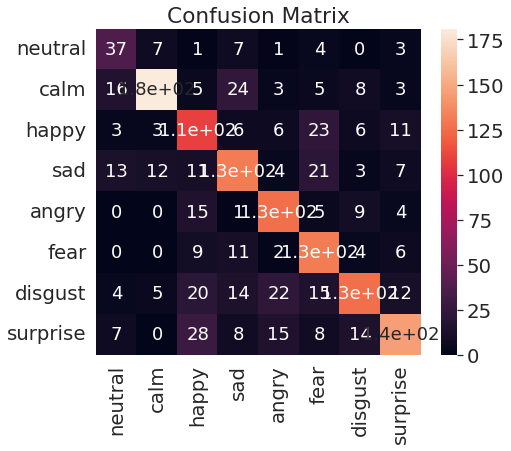

For only_mfcc_data
Accuracy score :  0.6708333333333333
              precision    recall  f1-score   support

           1       0.64      0.51      0.57        80
           2       0.70      0.88      0.78       208
           3       0.64      0.56      0.60       198
           4       0.65      0.58      0.61       202
           5       0.76      0.70      0.73       179
           6       0.82      0.59      0.69       212
           7       0.56      0.70      0.62       170
           8       0.62      0.75      0.68       191

    accuracy                           0.67      1440
   macro avg       0.67      0.66      0.66      1440
weighted avg       0.68      0.67      0.67      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        41     6      1    9      0     4        1         2
calm           13   183      6   31      5     8       11         4
happy           5     4    111    7      6    25        5        10
sad            11    

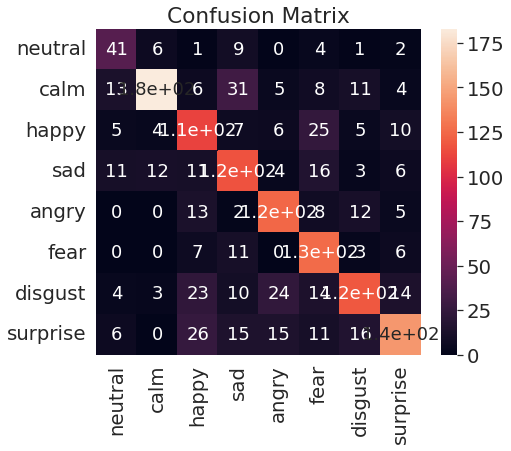

For all_features_data
Accuracy score :  0.8305555555555556
              precision    recall  f1-score   support

           1       0.85      0.69      0.76        80
           2       0.87      0.94      0.90       208
           3       0.79      0.78      0.78       198
           4       0.86      0.82      0.84       202
           5       0.92      0.84      0.88       179
           6       0.92      0.81      0.86       212
           7       0.75      0.82      0.79       170
           8       0.73      0.86      0.79       191

    accuracy                           0.83      1440
   macro avg       0.84      0.82      0.82      1440
weighted avg       0.84      0.83      0.83      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        55     3      1    2      1     0        2         1
calm           10   196      2   14      0     1        1         2
happy           6     3    154   11      0    10        3         9
sad             7 

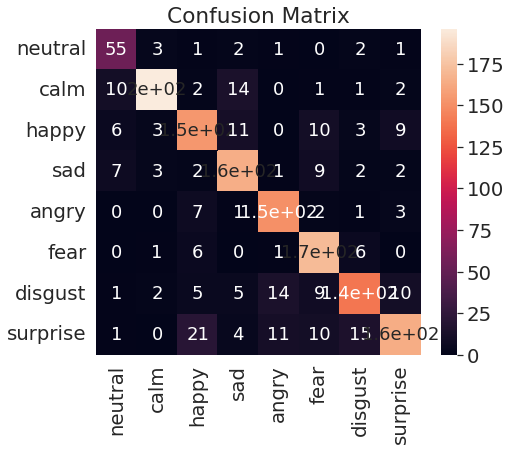

In [63]:
model_aug3 = xgb.XGBClassifier(random_state=39)
model_classifier(model_aug3,aug_dict,"Xgboost Classifier",aug_model_dict)

Ensemble model LightGBM

In [64]:
model_augtest = LGBMClassifier(random_state=39)
model_augtest.fit(agtd_x_train.values,agtd_y_train.values)
y_pred = model_augtest.predict(agtd_x_test.values)
print(len(y_pred))


1440


Model : LGBM Classifier
For time_domain_data
Accuracy score :  0.46458333333333335
              precision    recall  f1-score   support

           1       0.42      0.41      0.42        80
           2       0.54      0.67      0.60       208
           3       0.42      0.39      0.40       198
           4       0.43      0.31      0.36       202
           5       0.52      0.50      0.51       179
           6       0.52      0.33      0.41       212
           7       0.46      0.55      0.50       170
           8       0.39      0.54      0.45       191

    accuracy                           0.46      1440
   macro avg       0.46      0.46      0.46      1440
weighted avg       0.47      0.46      0.46      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        33     9      7    9      1     6        6         7
calm           19   139     10   51      3    11       13        12
happy           8    11     77   20     16    23        7     

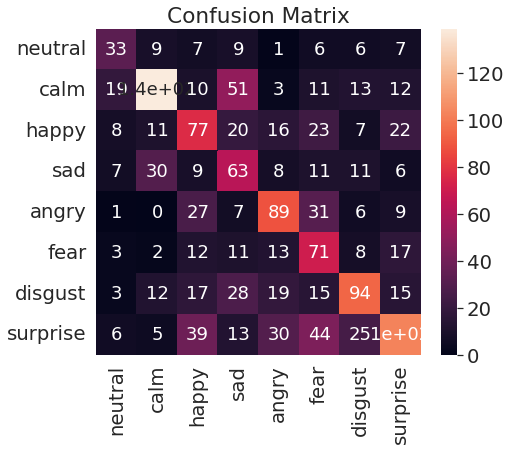

For frequency_domain_data
Accuracy score :  0.9854166666666667
              precision    recall  f1-score   support

           1       1.00      0.99      0.99        80
           2       0.99      1.00      0.99       208
           3       0.97      0.98      0.98       198
           4       1.00      1.00      1.00       202
           5       0.99      0.97      0.98       179
           6       1.00      0.99      0.99       212
           7       0.97      0.99      0.98       170
           8       0.97      0.96      0.96       191

    accuracy                           0.99      1440
   macro avg       0.99      0.99      0.99      1440
weighted avg       0.99      0.99      0.99      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        79     0      0    0      0     0        0         0
calm            0   208      2    0      0     0        1         0
happy           0     0    195    0      1     0        0         4
sad           

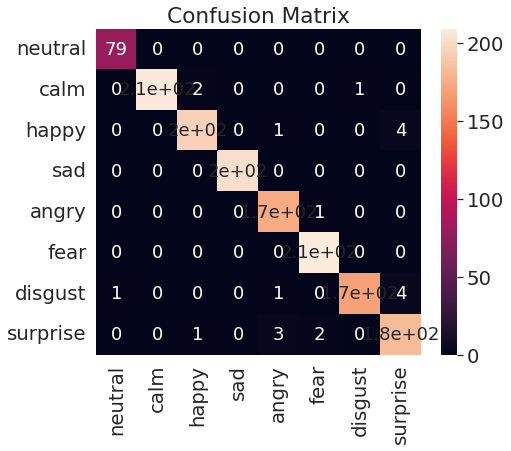

For spectral_domain_data
Accuracy score :  0.8826388888888889
              precision    recall  f1-score   support

           1       0.82      0.70      0.76        80
           2       0.91      0.96      0.93       208
           3       0.87      0.87      0.87       198
           4       0.87      0.93      0.90       202
           5       0.94      0.84      0.88       179
           6       0.93      0.88      0.91       212
           7       0.83      0.91      0.87       170
           8       0.85      0.87      0.86       191

    accuracy                           0.88      1440
   macro avg       0.88      0.87      0.87      1440
weighted avg       0.88      0.88      0.88      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        56     5      1    3      0     0        1         2
calm            9   199      0    3      3     2        3         0
happy           0     0    173    1      5     9        3         8
sad            

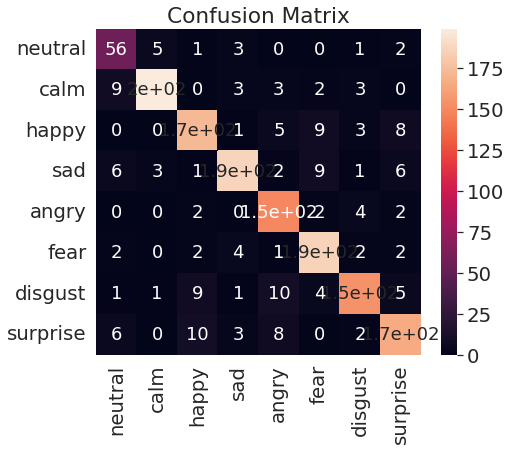

For only_mfcc_data
Accuracy score :  0.8951388888888889
              precision    recall  f1-score   support

           1       0.86      0.76      0.81        80
           2       0.93      0.95      0.94       208
           3       0.88      0.90      0.89       198
           4       0.93      0.93      0.93       202
           5       0.91      0.83      0.87       179
           6       0.95      0.90      0.92       212
           7       0.83      0.92      0.87       170
           8       0.85      0.88      0.87       191

    accuracy                           0.90      1440
   macro avg       0.89      0.88      0.89      1440
weighted avg       0.90      0.90      0.89      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        61     6      0    2      0     0        2         0
calm            6   197      1    2      2     1        2         1
happy           1     0    179    1      4     7        3         8
sad             3    

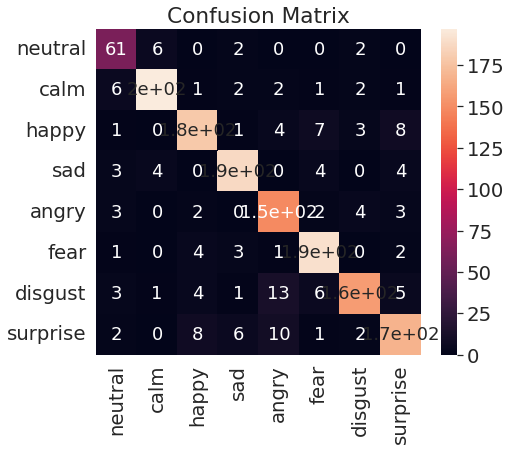

For all_features_data
Accuracy score :  0.9826388888888888
              precision    recall  f1-score   support

           1       0.99      0.96      0.97        80
           2       0.99      1.00      1.00       208
           3       0.97      0.97      0.97       198
           4       1.00      1.00      1.00       202
           5       1.00      0.98      0.99       179
           6       0.98      1.00      0.99       212
           7       0.98      0.99      0.98       170
           8       0.96      0.95      0.96       191

    accuracy                           0.98      1440
   macro avg       0.98      0.98      0.98      1440
weighted avg       0.98      0.98      0.98      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        77     0      0    0      0     0        0         1
calm            1   208      1    0      0     0        0         0
happy           0     0    192    0      0     0        0         6
sad             1 

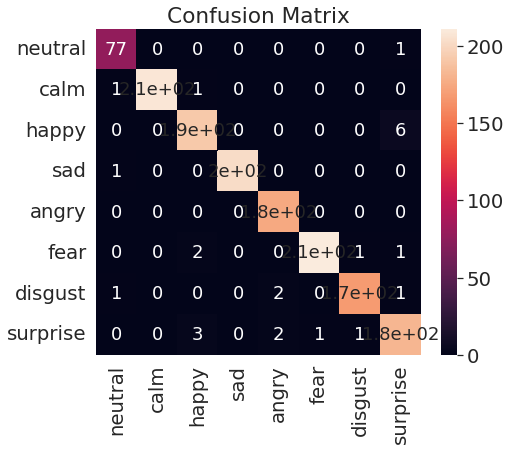

In [65]:
model_aug4 = LGBMClassifier(random_state=39)
model_classifier(model_aug4,aug_dict,"LGBM Classifier",aug_model_dict)

Ensemble model Adaboost

Model : Adaboost Classifier
For time_domain_data
Accuracy score :  0.2951388888888889
              precision    recall  f1-score   support

           1       0.20      0.30      0.24        80
           2       0.48      0.56      0.52       208
           3       0.16      0.12      0.14       198
           4       0.22      0.10      0.14       202
           5       0.26      0.67      0.37       179
           6       0.30      0.03      0.05       212
           7       0.36      0.36      0.36       170
           8       0.28      0.27      0.28       191

    accuracy                           0.30      1440
   macro avg       0.28      0.30      0.26      1440
weighted avg       0.29      0.30      0.26      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        24    38     12   21      1     7        7        11
calm           19   117     10   52      8    13       13        11
happy           6    22     23   29     11    18       15  

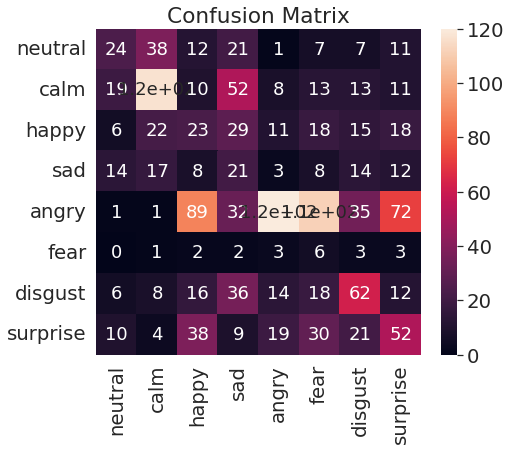

For frequency_domain_data
Accuracy score :  0.31180555555555556
              precision    recall  f1-score   support

           1       0.27      0.17      0.21        80
           2       0.62      0.67      0.64       208
           3       0.23      0.10      0.14       198
           4       0.25      0.31      0.27       202
           5       0.27      0.72      0.39       179
           6       0.10      0.03      0.05       212
           7       0.20      0.14      0.17       170
           8       0.34      0.29      0.32       191

    accuracy                           0.31      1440
   macro avg       0.29      0.30      0.27      1440
weighted avg       0.29      0.31      0.28      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        14    13      6    8      1     1        5         4
calm           24   139      2   45      0     6        6         2
happy          12     0     19   10     13     8       13         7
sad          

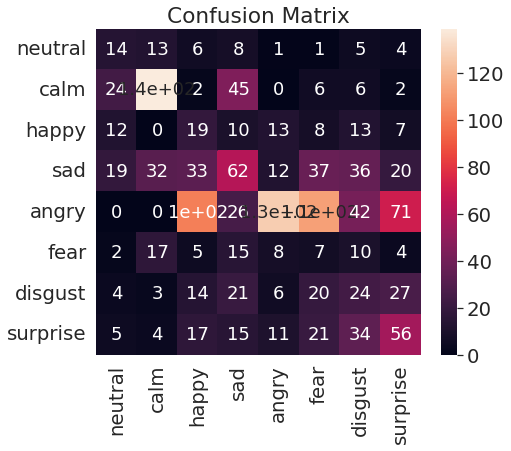

For spectral_domain_data
Accuracy score :  0.36666666666666664
              precision    recall  f1-score   support

           1       0.23      0.28      0.25        80
           2       0.65      0.68      0.66       208
           3       0.28      0.23      0.25       198
           4       0.29      0.25      0.27       202
           5       0.36      0.39      0.37       179
           6       0.37      0.21      0.27       212
           7       0.30      0.35      0.32       170
           8       0.35      0.50      0.41       191

    accuracy                           0.37      1440
   macro avg       0.35      0.36      0.35      1440
weighted avg       0.37      0.37      0.36      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        22    20      7   24      1    10        9         2
calm           15   141      4   38      0     4       12         4
happy           4     3     45   24     25    29       16        16
sad           

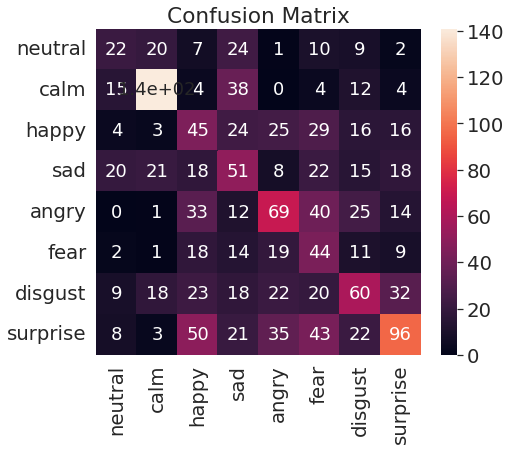

For only_mfcc_data
Accuracy score :  0.35833333333333334
              precision    recall  f1-score   support

           1       0.19      0.24      0.21        80
           2       0.59      0.71      0.65       208
           3       0.25      0.20      0.22       198
           4       0.31      0.23      0.26       202
           5       0.29      0.47      0.36       179
           6       0.46      0.15      0.22       212
           7       0.34      0.36      0.35       170
           8       0.35      0.45      0.39       191

    accuracy                           0.36      1440
   macro avg       0.35      0.35      0.33      1440
weighted avg       0.37      0.36      0.34      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        19    22      8   20      1     8       11         9
calm           27   148      7   44      3     2       17         2
happy           3     1     39   30     27    21       16        16
sad            12   

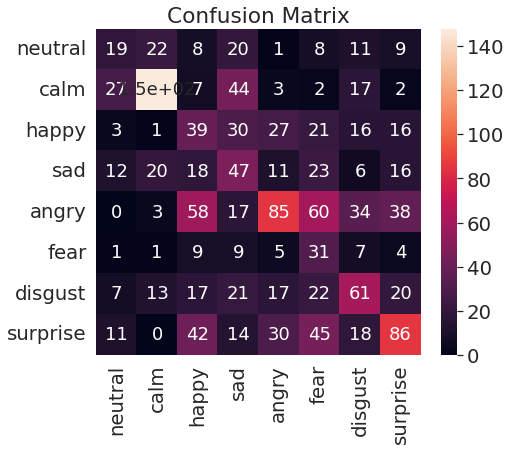

For all_features_data
Accuracy score :  0.35833333333333334
              precision    recall  f1-score   support

           1       0.30      0.34      0.32        80
           2       0.60      0.84      0.70       208
           3       0.23      0.13      0.17       198
           4       0.29      0.13      0.18       202
           5       0.32      0.64      0.43       179
           6       0.29      0.28      0.29       212
           7       0.20      0.15      0.17       170
           8       0.38      0.33      0.35       191

    accuracy                           0.36      1440
   macro avg       0.33      0.35      0.33      1440
weighted avg       0.33      0.36      0.33      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        27    14     12   10      3     7       10         6
calm           26   174      3   68      1     5       11         4
happy           9     4     26   20      7    13       22        10
sad             7

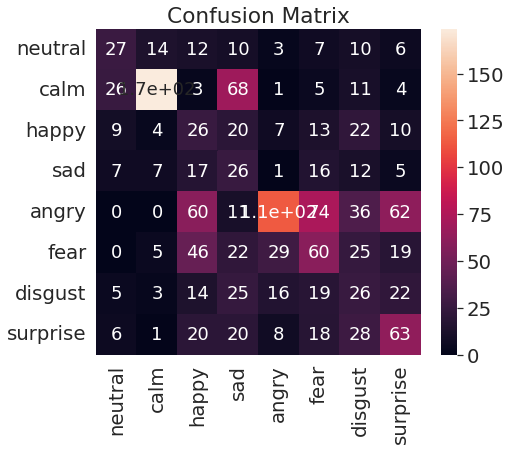

In [66]:
model_aug5 = AdaBoostClassifier(random_state=39)
model_classifier(model_aug5,aug_dict,"Adaboost Classifier",aug_model_dict)

Gaussian Naive bayes

Model : Gaussian naive Bayes Classifier
For time_domain_data
Accuracy score :  0.3333333333333333
              precision    recall  f1-score   support

           1       0.16      0.51      0.24        80
           2       0.49      0.65      0.56       208
           3       0.33      0.13      0.19       198
           4       0.28      0.10      0.15       202
           5       0.51      0.38      0.43       179
           6       0.39      0.11      0.18       212
           7       0.34      0.35      0.34       170
           8       0.28      0.55      0.37       191

    accuracy                           0.33      1440
   macro avg       0.35      0.35      0.31      1440
weighted avg       0.36      0.33      0.31      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        41    43     34   55      7    20       26        34
calm           21   135     11   51      8    13       24        10
happy           0     0     26   11     12    2

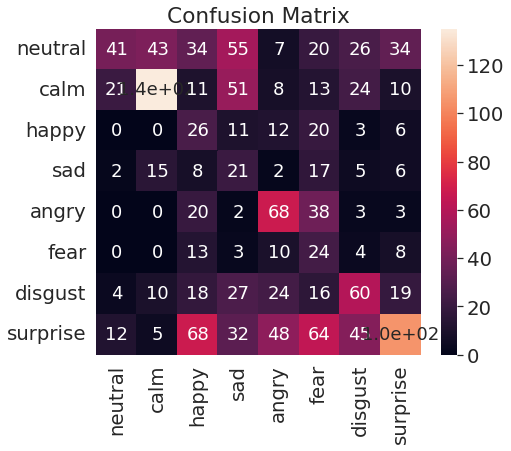

For frequency_domain_data
Accuracy score :  0.30833333333333335
              precision    recall  f1-score   support

           1       0.13      0.28      0.17        80
           2       0.37      0.91      0.53       208
           3       0.33      0.17      0.22       198
           4       0.14      0.17      0.15       202
           5       0.68      0.32      0.44       179
           6       0.56      0.17      0.26       212
           7       0.22      0.15      0.18       170
           8       0.31      0.24      0.27       191

    accuracy                           0.31      1440
   macro avg       0.34      0.30      0.28      1440
weighted avg       0.36      0.31      0.29      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        22     8     25   34     16    11       33        26
calm           51   190     23  112      7    40       44        44
happy           0     0     33    7     15    26       10         9
sad          

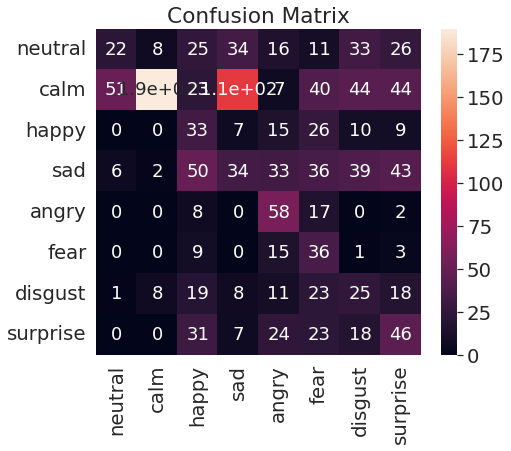

For spectral_domain_data
Accuracy score :  0.26319444444444445
              precision    recall  f1-score   support

           1       0.19      0.12      0.15        80
           2       0.43      0.64      0.52       208
           3       0.24      0.11      0.15       198
           4       0.50      0.01      0.02       202
           5       0.23      0.59      0.33       179
           6       0.00      0.00      0.00       212
           7       0.16      0.17      0.16       170
           8       0.23      0.40      0.29       191

    accuracy                           0.26      1440
   macro avg       0.25      0.26      0.20      1440
weighted avg       0.25      0.26      0.20      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        10    12      5    9      0     4        5         7
calm           27   134     13   69      7    15       28        17
happy           1     4     21   15     14    18       10         5
sad           

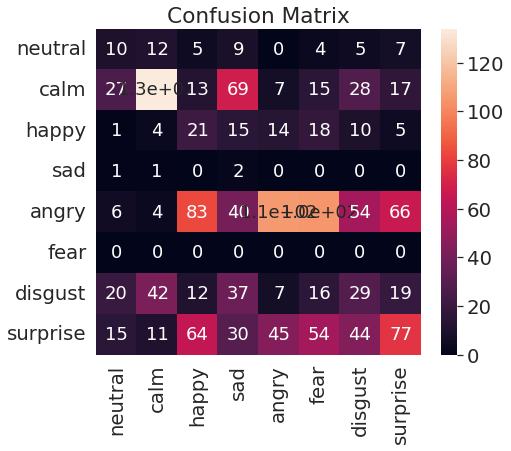

For only_mfcc_data
Accuracy score :  0.36527777777777776
              precision    recall  f1-score   support

           1       0.11      0.40      0.18        80
           2       0.49      0.64      0.56       208
           3       0.30      0.11      0.16       198
           4       0.27      0.08      0.13       202
           5       0.47      0.36      0.41       179
           6       0.53      0.40      0.45       212
           7       0.33      0.34      0.33       170
           8       0.42      0.60      0.49       191

    accuracy                           0.37      1440
   macro avg       0.37      0.37      0.34      1440
weighted avg       0.39      0.37      0.35      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        32    33     43   54     22    42       38        21
calm           19   134      9   54     10    18       25         3
happy           0     8     22   14      6    11        3         9
sad             1   

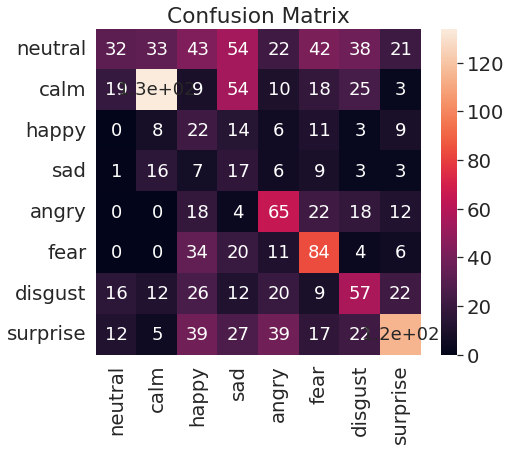

For all_features_data
Accuracy score :  0.27708333333333335
              precision    recall  f1-score   support

           1       0.19      0.12      0.15        80
           2       0.43      0.64      0.52       208
           3       0.28      0.13      0.17       198
           4       0.50      0.01      0.02       202
           5       0.27      0.55      0.36       179
           6       0.09      0.00      0.01       212
           7       0.18      0.23      0.20       170
           8       0.23      0.47      0.31       191

    accuracy                           0.28      1440
   macro avg       0.27      0.27      0.22      1440
weighted avg       0.28      0.28      0.22      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        10    12      5    9      0     4        5         7
calm           27   134     13   69      7    15       28        17
happy           0     2     25   17     11    18       10         5
sad             1

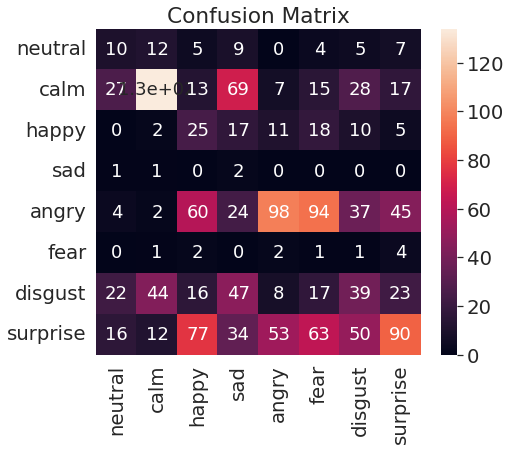

In [67]:
model_aug6 = GaussianNB()
model_classifier(model_aug6,aug_dict,"Gaussian naive Bayes Classifier",aug_model_dict)

Quadratic Discriminant Analysis(QDA)

Model : QDA
For time_domain_data
Accuracy score :  0.3194444444444444
              precision    recall  f1-score   support

           1       0.15      0.57      0.24        80
           2       0.50      0.59      0.54       208
           3       0.30      0.13      0.18       198
           4       0.27      0.06      0.10       202
           5       0.51      0.37      0.43       179
           6       0.37      0.08      0.13       212
           7       0.32      0.39      0.35       170
           8       0.28      0.54      0.37       191

    accuracy                           0.32      1440
   macro avg       0.34      0.34      0.29      1440
weighted avg       0.35      0.32      0.29      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        46    59     33   64      6    29       29        39
calm           16   123     11   48      7    12       20        10
happy           0     2     26   13     14    23        3         7
sad    

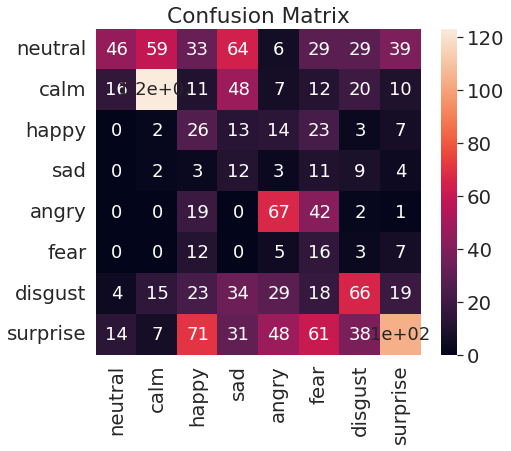

For frequency_domain_data
Accuracy score :  0.7854166666666667
              precision    recall  f1-score   support

           1       1.00      0.89      0.94        80
           2       0.73      0.98      0.84       208
           3       0.83      0.79      0.81       198
           4       0.72      0.73      0.73       202
           5       0.93      0.68      0.79       179
           6       0.85      0.68      0.75       212
           7       0.63      0.84      0.72       170
           8       0.85      0.74      0.79       191

    accuracy                           0.79      1440
   macro avg       0.82      0.79      0.80      1440
weighted avg       0.80      0.79      0.79      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        71     0      0    0      0     0        0         0
calm            0   204      4   48      1     6       12         4
happy           5     1    157    0     17    10        0         0
sad           

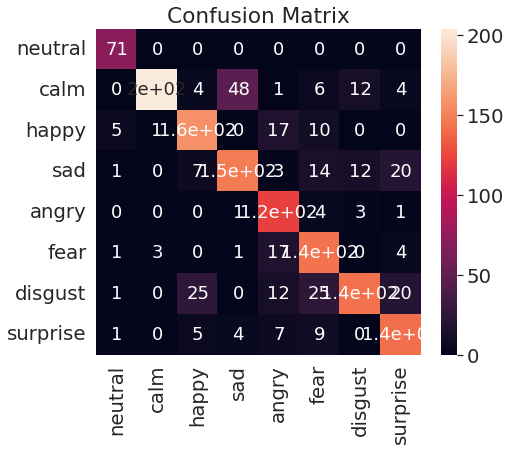

For spectral_domain_data
Accuracy score :  0.7763888888888889
              precision    recall  f1-score   support

           1       0.59      0.86      0.70        80
           2       0.79      0.91      0.85       208
           3       0.77      0.68      0.72       198
           4       0.82      0.72      0.77       202
           5       0.91      0.77      0.84       179
           6       0.85      0.63      0.72       212
           7       0.66      0.88      0.75       170
           8       0.80      0.83      0.81       191

    accuracy                           0.78      1440
   macro avg       0.77      0.79      0.77      1440
weighted avg       0.79      0.78      0.78      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        69    11      9   16      1     2        2         6
calm            4   190      6   23      1     7        4         4
happy           1     3    135    1      3    19        4        10
sad            

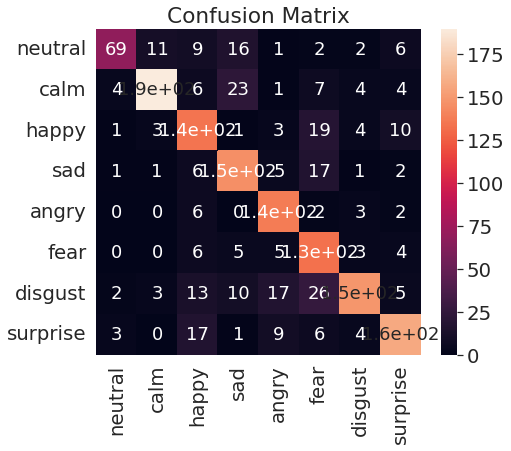

For only_mfcc_data
Accuracy score :  0.7048611111111112
              precision    recall  f1-score   support

           1       0.52      0.78      0.62        80
           2       0.73      0.90      0.81       208
           3       0.73      0.56      0.63       198
           4       0.72      0.57      0.64       202
           5       0.86      0.70      0.77       179
           6       0.77      0.58      0.66       212
           7       0.58      0.82      0.68       170
           8       0.74      0.80      0.77       191

    accuracy                           0.70      1440
   macro avg       0.71      0.71      0.70      1440
weighted avg       0.72      0.70      0.70      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        62    14      8   24      0     2        4         5
calm            7   188     11   29      3     9        8         3
happy           1     0    110    2      6    16        3        12
sad             2    

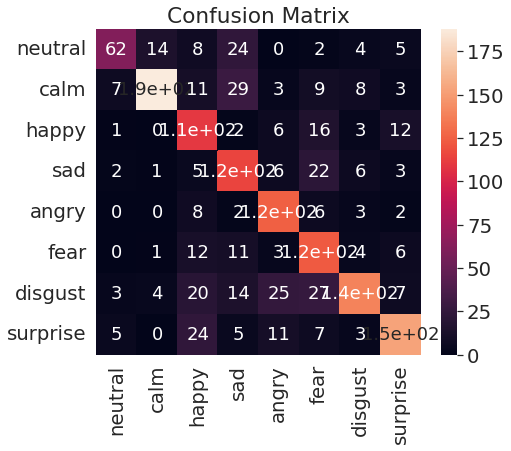

For all_features_data
Accuracy score :  0.8798611111111111
              precision    recall  f1-score   support

           1       1.00      0.80      0.89        80
           2       0.82      0.98      0.89       208
           3       0.84      0.89      0.86       198
           4       0.87      0.83      0.85       202
           5       0.94      0.79      0.86       179
           6       0.91      0.82      0.86       212
           7       0.82      0.96      0.88       170
           8       0.96      0.92      0.94       191

    accuracy                           0.88      1440
   macro avg       0.89      0.87      0.88      1440
weighted avg       0.89      0.88      0.88      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        64     0      0    0      0     0        0         0
calm            1   204      1   29      1     5        4         4
happy           7     1    176    4     17     0        0         4
sad             3 

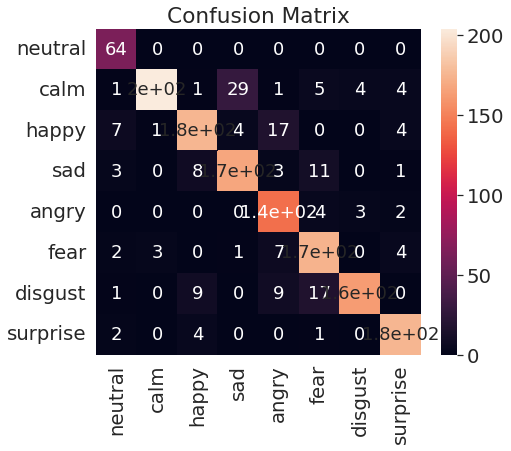

In [68]:
model_aug7 = QuadraticDiscriminantAnalysis()
model_classifier(model_aug7,aug_dict,"QDA",aug_model_dict)

Linear Discriminant Analysis(LDA)

Model : LDA
For time_domain_data
Accuracy score :  0.2972222222222222
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        80
           2       0.39      0.51      0.44       208
           3       0.31      0.15      0.20       198
           4       0.17      0.10      0.12       202
           5       0.48      0.41      0.44       179
           6       0.35      0.12      0.18       212
           7       0.27      0.39      0.32       170
           8       0.23      0.55      0.32       191

    accuracy                           0.30      1440
   macro avg       0.27      0.28      0.25      1440
weighted avg       0.29      0.30      0.27      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         0     0      0    0      0     0        0         1
calm           18   107     26   58      8    25       22        12
happy           1     5     29   12     16    12        5        15
sad    

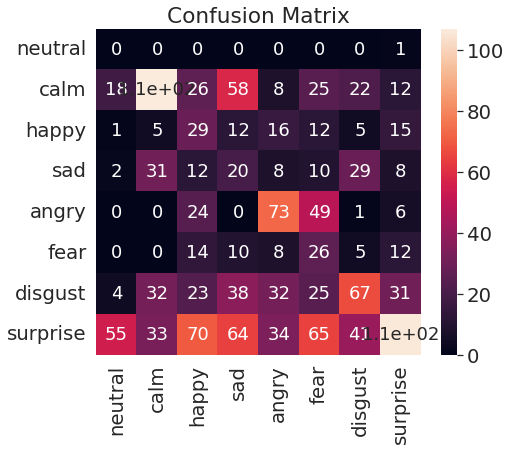

For frequency_domain_data
Accuracy score :  0.46944444444444444
              precision    recall  f1-score   support

           1       0.22      0.30      0.26        80
           2       0.59      0.67      0.63       208
           3       0.34      0.31      0.32       198
           4       0.39      0.38      0.38       202
           5       0.90      0.40      0.55       179
           6       0.70      0.42      0.53       212
           7       0.31      0.46      0.37       170
           8       0.52      0.72      0.61       191

    accuracy                           0.47      1440
   macro avg       0.50      0.46      0.46      1440
weighted avg       0.52      0.47      0.47      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        24    28     18   11      5     9       11         1
calm           22   140     15   41      2    11        6         0
happy          10     3     61   29     21    23       21        11
sad          

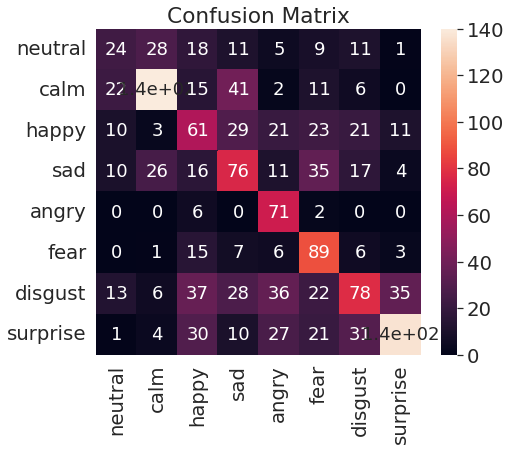

For spectral_domain_data
Accuracy score :  0.5111111111111111
              precision    recall  f1-score   support

           1       0.24      0.28      0.26        80
           2       0.71      0.72      0.72       208
           3       0.43      0.37      0.40       198
           4       0.46      0.47      0.46       202
           5       0.62      0.57      0.59       179
           6       0.57      0.42      0.49       212
           7       0.46      0.59      0.52       170
           8       0.46      0.55      0.50       191

    accuracy                           0.51      1440
   macro avg       0.50      0.50      0.49      1440
weighted avg       0.52      0.51      0.51      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        22    18      8   16      1     7        3        15
calm            8   150      1   40      0     3        8         0
happy           5     5     73   10     12    34       10        19
sad            

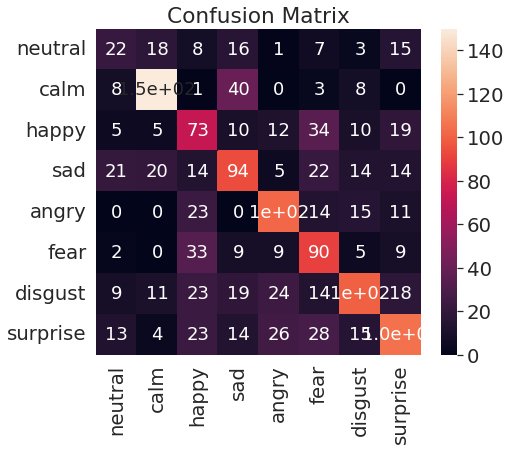

For only_mfcc_data
Accuracy score :  0.4791666666666667
              precision    recall  f1-score   support

           1       0.32      0.24      0.27        80
           2       0.57      0.69      0.63       208
           3       0.41      0.37      0.39       198
           4       0.46      0.49      0.47       202
           5       0.62      0.60      0.61       179
           6       0.51      0.39      0.44       212
           7       0.41      0.54      0.46       170
           8       0.43      0.39      0.41       191

    accuracy                           0.48      1440
   macro avg       0.46      0.46      0.46      1440
weighted avg       0.48      0.48      0.47      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        19    17      6    5      1     3        2         7
calm           14   144      4   45      2    13       20        10
happy           3     2     73   14      9    31       15        33
sad            23    

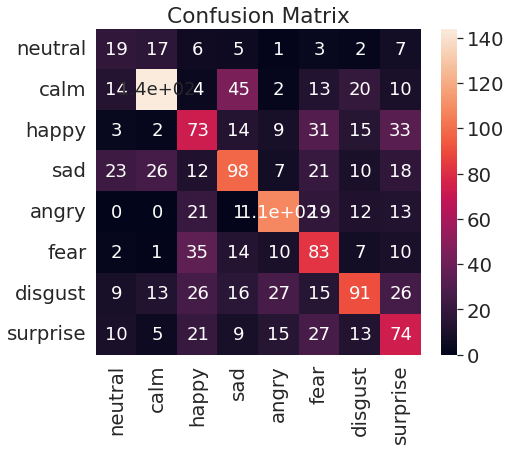

For all_features_data
Accuracy score :  0.6486111111111111
              precision    recall  f1-score   support

           1       0.37      0.59      0.45        80
           2       0.77      0.78      0.78       208
           3       0.50      0.55      0.53       198
           4       0.63      0.60      0.62       202
           5       0.94      0.56      0.70       179
           6       0.79      0.59      0.67       212
           7       0.61      0.69      0.65       170
           8       0.65      0.78      0.71       191

    accuracy                           0.65      1440
   macro avg       0.66      0.64      0.64      1440
weighted avg       0.68      0.65      0.65      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        47    29     14   14      3     4        7         9
calm            9   163      2   33      0     4        1         0
happy           6     1    109   16     21    29       18        17
sad             7 

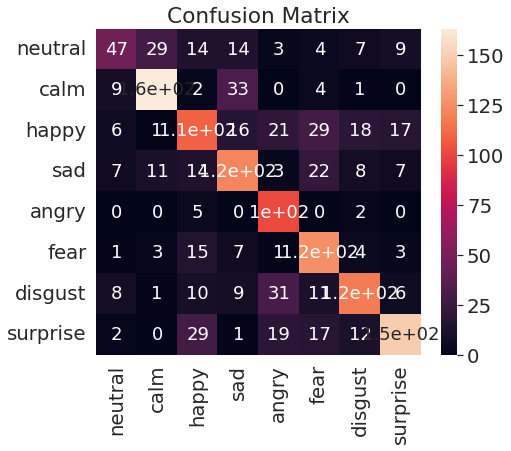

In [69]:
model_aug8 = LinearDiscriminantAnalysis()
model_classifier(model_aug8,aug_dict,"LDA",aug_model_dict)

Multilayer Perceptron Classifier

Model : MLP Classifier
For time_domain_data
Accuracy score :  0.3368055555555556
              precision    recall  f1-score   support

           1       0.26      0.10      0.14        80
           2       0.45      0.75      0.56       208
           3       0.28      0.19      0.22       198
           4       0.18      0.12      0.15       202
           5       0.46      0.39      0.42       179
           6       0.40      0.17      0.24       212
           7       0.26      0.35      0.30       170
           8       0.29      0.49      0.37       191

    accuracy                           0.34      1440
   macro avg       0.32      0.32      0.30      1440
weighted avg       0.33      0.34      0.31      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         8     4      5    2      1     5        1         5
calm           34   156     12   80      5    14       24        20
happy           1     5     37   20     17    23       12       

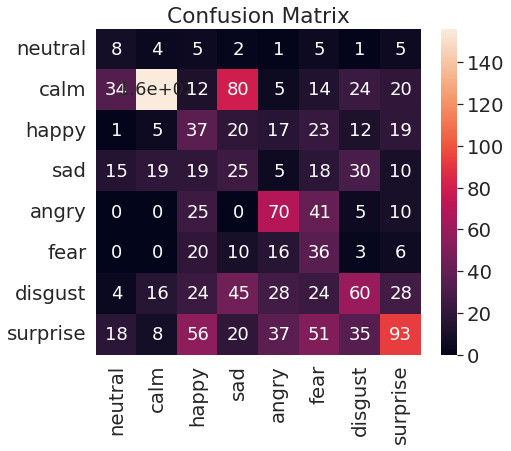

For frequency_domain_data
Accuracy score :  0.88125
              precision    recall  f1-score   support

           1       0.74      0.84      0.78        80
           2       0.79      0.91      0.85       208
           3       0.92      0.96      0.94       198
           4       0.86      0.72      0.78       202
           5       0.98      0.91      0.94       179
           6       0.93      0.85      0.89       212
           7       0.85      0.95      0.90       170
           8       0.94      0.90      0.92       191

    accuracy                           0.88      1440
   macro avg       0.88      0.88      0.88      1440
weighted avg       0.89      0.88      0.88      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        67     9      0   10      0     3        1         1
calm           11   190      2   31      0     4        2         0
happy           0     0    190    2      6     9        0         0
sad             2     8  

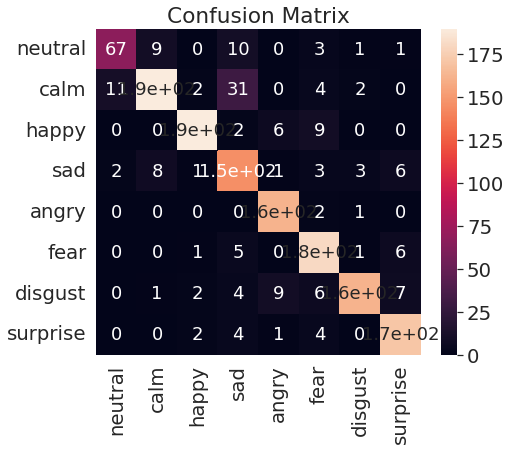

For spectral_domain_data
Accuracy score :  0.1909722222222222
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        80
           2       0.41      0.37      0.39       208
           3       0.17      0.93      0.28       198
           4       0.17      0.00      0.01       202
           5       0.00      0.00      0.00       179
           6       0.00      0.00      0.00       212
           7       0.08      0.04      0.05       170
           8       0.09      0.04      0.05       191

    accuracy                           0.19      1440
   macro avg       0.11      0.17      0.10      1440
weighted avg       0.13      0.19      0.11      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         0     0      0    0      0     0        0         0
calm           15    77      7   39      4    13       18        14
happy          44    68    184  131    173   192      136       168
sad            

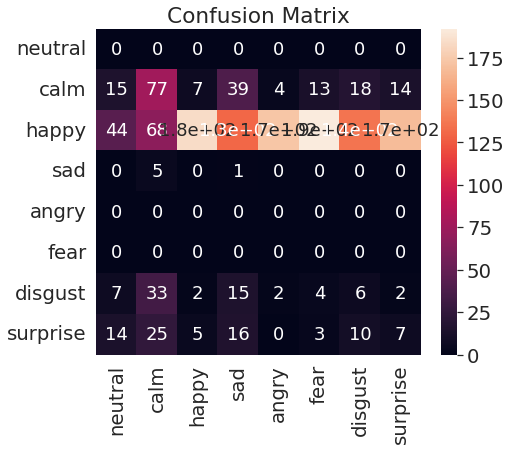

For only_mfcc_data
Accuracy score :  0.6041666666666666
              precision    recall  f1-score   support

           1       0.45      0.45      0.45        80
           2       0.66      0.81      0.73       208
           3       0.62      0.48      0.54       198
           4       0.58      0.41      0.48       202
           5       0.62      0.70      0.66       179
           6       0.64      0.79      0.71       212
           7       0.50      0.50      0.50       170
           8       0.63      0.57      0.60       191

    accuracy                           0.60      1440
   macro avg       0.59      0.59      0.58      1440
weighted avg       0.60      0.60      0.60      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        36    10      8    8      1     3       10         4
calm           14   169      7   39      1     3       13         9
happy           1     1     96   17      5    10       10        16
sad             9    

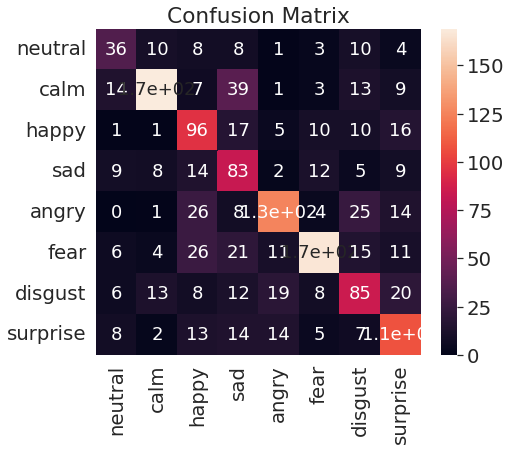

For all_features_data
Accuracy score :  0.07569444444444444
              precision    recall  f1-score   support

           1       0.06      0.75      0.11        80
           2       0.00      0.00      0.00       208
           3       0.15      0.17      0.16       198
           4       0.00      0.00      0.00       202
           5       0.00      0.00      0.00       179
           6       0.07      0.06      0.07       212
           7       0.03      0.01      0.02       170
           8       0.00      0.00      0.00       191

    accuracy                           0.08      1440
   macro avg       0.04      0.12      0.04      1440
weighted avg       0.04      0.08      0.04      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        60   106    155  135     95   140      141       154
calm            0     0      0    0      0     0        0         0
happy           0     0     34   15     78    58       15        21
sad             0

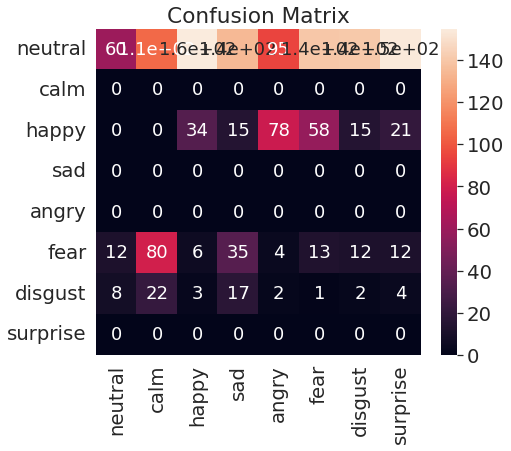

In [70]:
model_aug9 = MLPClassifier(random_state=39, max_iter=1000)
model_classifier(model_aug9,aug_dict,"MLP Classifier",aug_model_dict)

KNN Classifier

Model : KNN
For time_domain_data
Accuracy score :  0.33194444444444443
              precision    recall  f1-score   support

           1       0.18      0.35      0.24        80
           2       0.40      0.50      0.44       208
           3       0.32      0.40      0.36       198
           4       0.24      0.19      0.21       202
           5       0.49      0.39      0.43       179
           6       0.39      0.26      0.32       212
           7       0.28      0.30      0.29       170
           8       0.34      0.28      0.31       191

    accuracy                           0.33      1440
   macro avg       0.33      0.33      0.32      1440
weighted avg       0.34      0.33      0.33      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        28    39     16   30      7    11       13        14
calm           20   103     16   47     10    20       22        18
happy           7     8     79   27     30    42       18        34
sad   

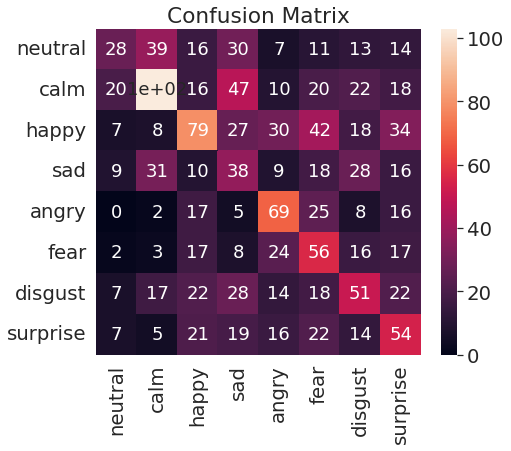

For frequency_domain_data
Accuracy score :  0.7756944444444445
              precision    recall  f1-score   support

           1       0.68      0.93      0.78        80
           2       0.89      0.89      0.89       208
           3       0.68      0.73      0.70       198
           4       0.81      0.72      0.76       202
           5       0.83      0.80      0.81       179
           6       0.90      0.73      0.80       212
           7       0.70      0.78      0.74       170
           8       0.70      0.73      0.72       191

    accuracy                           0.78      1440
   macro avg       0.77      0.79      0.78      1440
weighted avg       0.78      0.78      0.78      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        74    10      5   13      0     1        1         5
calm            0   185      3   14      0     2        2         3
happy           0     0    144   14      8    17        9        20
sad           

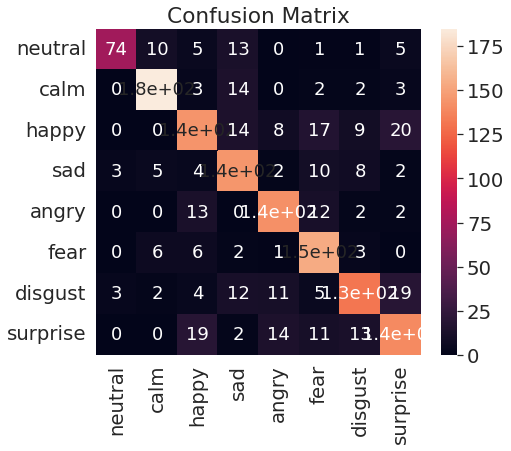

For spectral_domain_data
Accuracy score :  0.2375
              precision    recall  f1-score   support

           1       0.15      0.24      0.18        80
           2       0.35      0.45      0.39       208
           3       0.19      0.24      0.21       198
           4       0.18      0.14      0.16       202
           5       0.28      0.32      0.30       179
           6       0.26      0.14      0.18       212
           7       0.18      0.17      0.18       170
           8       0.23      0.20      0.21       191

    accuracy                           0.24      1440
   macro avg       0.23      0.24      0.23      1440
weighted avg       0.24      0.24      0.23      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        19    36      9   22      6     6       12        17
calm           23    93     15   50      6    23       29        24
happy           8    15     47   30     43    42       28        30
sad            13    26    

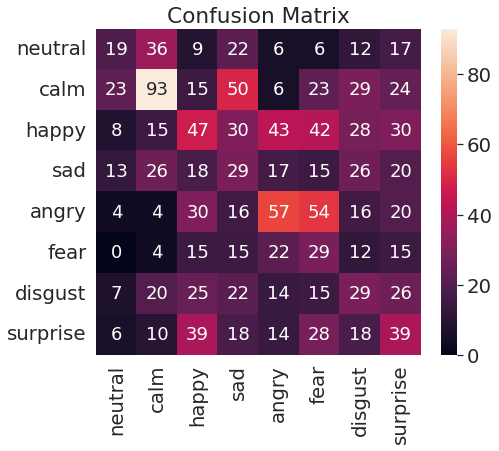

For only_mfcc_data
Accuracy score :  0.5569444444444445
              precision    recall  f1-score   support

           1       0.29      0.49      0.36        80
           2       0.65      0.77      0.70       208
           3       0.47      0.52      0.49       198
           4       0.54      0.49      0.51       202
           5       0.63      0.61      0.62       179
           6       0.72      0.51      0.60       212
           7       0.49      0.52      0.50       170
           8       0.62      0.50      0.56       191

    accuracy                           0.56      1440
   macro avg       0.55      0.55      0.54      1440
weighted avg       0.58      0.56      0.56      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        39    20      9   28      6    11        8        13
calm           17   160      8   39      2     6       10         6
happy           3     6    103   16     16    31       19        25
sad            12    

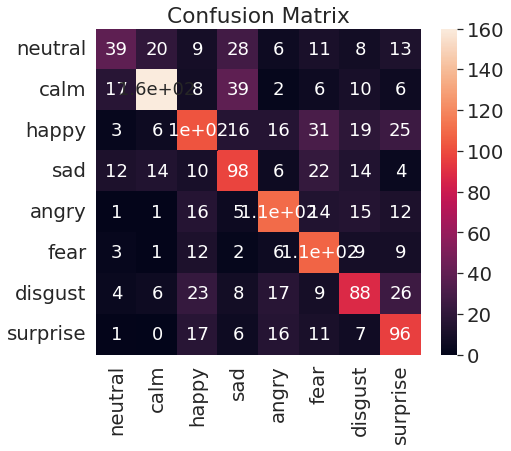

For all_features_data
Accuracy score :  0.2375
              precision    recall  f1-score   support

           1       0.15      0.24      0.18        80
           2       0.35      0.45      0.39       208
           3       0.19      0.24      0.21       198
           4       0.18      0.14      0.16       202
           5       0.28      0.32      0.30       179
           6       0.26      0.14      0.18       212
           7       0.18      0.17      0.18       170
           8       0.23      0.20      0.21       191

    accuracy                           0.24      1440
   macro avg       0.23      0.24      0.23      1440
weighted avg       0.24      0.24      0.23      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        19    36      9   22      6     6       12        17
calm           23    93     15   50      6    23       29        24
happy           8    15     47   30     43    42       28        30
sad            13    26     18

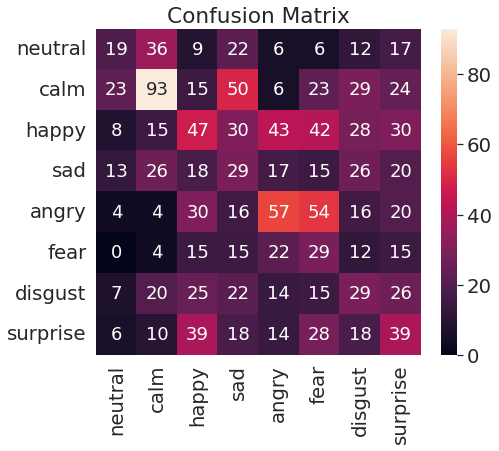

In [71]:
model_aug10 = KNeighborsClassifier()
model_classifier(model_aug10,aug_dict,"KNN",aug_model_dict)

SVC

Model : SVC
For time_domain_data
Accuracy score :  0.36319444444444443
              precision    recall  f1-score   support

           1       0.24      0.19      0.21        80
           2       0.44      0.76      0.55       208
           3       0.32      0.21      0.26       198
           4       0.24      0.13      0.17       202
           5       0.51      0.40      0.45       179
           6       0.49      0.18      0.26       212
           7       0.32      0.41      0.36       170
           8       0.31      0.54      0.39       191

    accuracy                           0.36      1440
   macro avg       0.36      0.35      0.33      1440
weighted avg       0.37      0.36      0.34      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        15     8     11    6      1     6        2        13
calm           34   158     18   81      6    18       29        19
happy           2     6     42   20     20    22        7        12
sad   

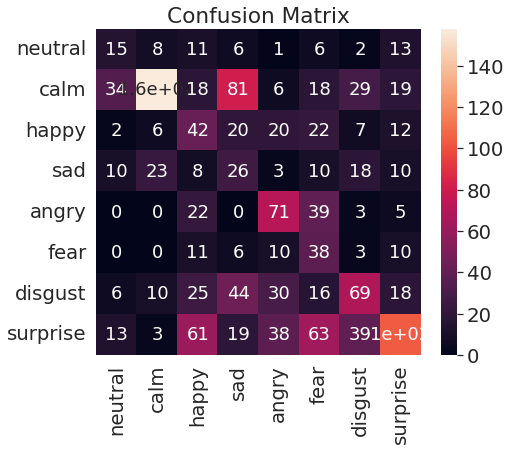

For frequency_domain_data
Accuracy score :  0.71875
              precision    recall  f1-score   support

           1       0.43      0.45      0.44        80
           2       0.67      0.80      0.73       208
           3       0.78      0.76      0.77       198
           4       0.61      0.55      0.58       202
           5       0.91      0.77      0.84       179
           6       0.88      0.81      0.84       212
           7       0.56      0.66      0.60       170
           8       0.82      0.77      0.80       191

    accuracy                           0.72      1440
   macro avg       0.71      0.70      0.70      1440
weighted avg       0.73      0.72      0.72      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        36    17      5   13      5     5        2         1
calm           26   167      5   37      0     4       10         2
happy           3     2    151    7      9     1       11         9
sad             4    17  

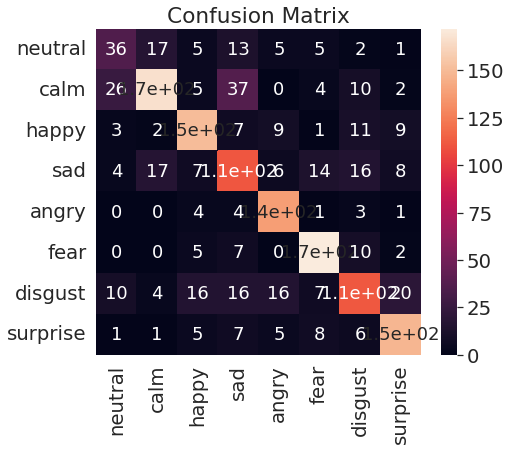

For spectral_domain_data
Accuracy score :  0.2833333333333333
              precision    recall  f1-score   support

           1       1.00      0.01      0.02        80
           2       0.36      0.81      0.50       208
           3       0.28      0.05      0.08       198
           4       0.00      0.00      0.00       202
           5       0.32      0.50      0.39       179
           6       0.00      0.00      0.00       212
           7       0.21      0.37      0.27       170
           8       0.22      0.40      0.28       191

    accuracy                           0.28      1440
   macro avg       0.30      0.27      0.19      1440
weighted avg       0.24      0.28      0.20      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         1     0      0    0      0     0        0         0
calm           55   169     25  105      9    26       43        36
happy           1     0      9    0     10     5        1         6
sad            

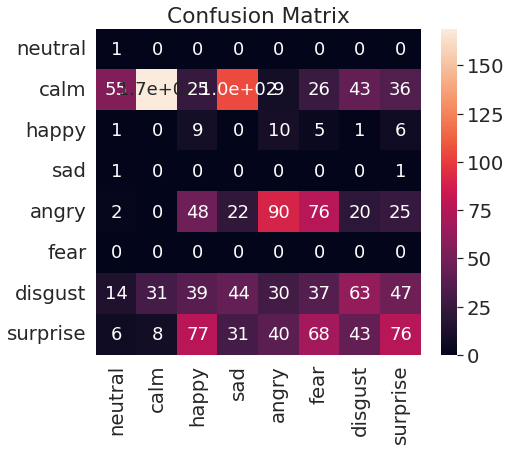

For only_mfcc_data
Accuracy score :  0.6597222222222222
              precision    recall  f1-score   support

           1       0.52      0.57      0.55        80
           2       0.74      0.83      0.78       208
           3       0.62      0.55      0.58       198
           4       0.61      0.62      0.61       202
           5       0.74      0.73      0.73       179
           6       0.71      0.66      0.68       212
           7       0.58      0.65      0.61       170
           8       0.68      0.62      0.65       191

    accuracy                           0.66      1440
   macro avg       0.65      0.65      0.65      1440
weighted avg       0.66      0.66      0.66      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral        46    14      3    8      1     3        3        10
calm            8   172      3   28      2     4        9         6
happy           3     1    109    7      5    23        9        20
sad            14    

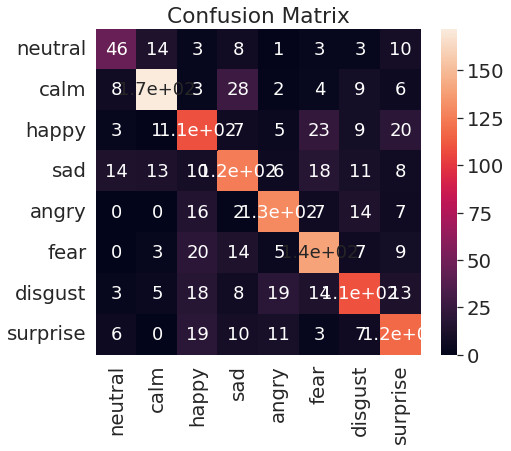

For all_features_data
Accuracy score :  0.2833333333333333
              precision    recall  f1-score   support

           1       1.00      0.01      0.02        80
           2       0.36      0.81      0.50       208
           3       0.25      0.03      0.05       198
           4       0.00      0.00      0.00       202
           5       0.32      0.50      0.39       179
           6       0.00      0.00      0.00       212
           7       0.21      0.37      0.27       170
           8       0.22      0.41      0.29       191

    accuracy                           0.28      1440
   macro avg       0.29      0.27      0.19      1440
weighted avg       0.24      0.28      0.20      1440

          neutral  calm  happy  sad  angry  fear  disgust  surprise
neutral         1     0      0    0      0     0        0         0
calm           56   169     25  106      9    26       43        36
happy           0     0      6    0      9     5        1         3
sad             1 

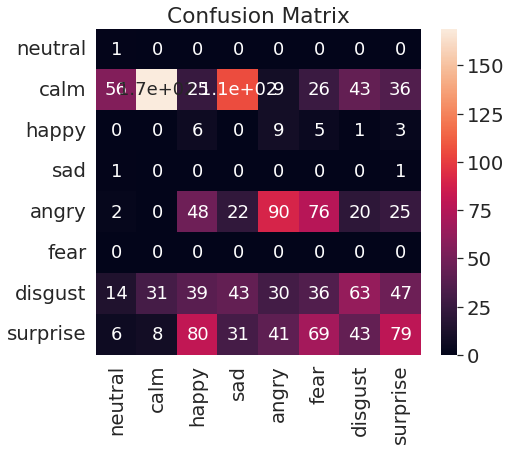

In [101]:
model_aug11 = SVC(random_state=39,C=10000)
model_classifier(model_aug11,aug_dict,"SVC",aug_model_dict)

In [73]:
import pickle
d = model_dict['LGBM Classifier']['time_domain_data']
pickle.dump(d,open('classifier.pkl','wb'))

In [74]:
print(aug_model_dict)

{'Decision Tree Classifier': {'time_domain_data': DecisionTreeClassifier(random_state=39), 'frequency_domain_data': DecisionTreeClassifier(random_state=39), 'spectral_domain_data': DecisionTreeClassifier(random_state=39), 'only_mfcc_data': DecisionTreeClassifier(random_state=39), 'all_features_data': DecisionTreeClassifier(random_state=39)}, 'Random ForestClassifier': {'time_domain_data': RandomForestClassifier(random_state=39), 'frequency_domain_data': RandomForestClassifier(random_state=39), 'spectral_domain_data': RandomForestClassifier(random_state=39), 'only_mfcc_data': RandomForestClassifier(random_state=39), 'all_features_data': RandomForestClassifier(random_state=39)}, 'Xgboost Classifier': {'time_domain_data': XGBClassifier(objective='multi:softprob', random_state=39), 'frequency_domain_data': XGBClassifier(objective='multi:softprob', random_state=39), 'spectral_domain_data': XGBClassifier(objective='multi:softprob', random_state=39), 'only_mfcc_data': XGBClassifier(objective=

In [75]:
for k in aug_model_dict["LGBM Classifier"]:
  name=str(k)+".pkl"
  pickle.dump(aug_model_dict["LGBM Classifier"][k],open(name,"wb"))